# Classification Analysis
This notebook will contain classification analysis for both the sensed and pipelined algorithms. Analysis will be preformed in regards for the sensed and pipelined algorthms themselves, as well as the ensemble algorithms. The analysis for the ensemble algorithm will focus on the HAMF android phones and the HAHF iOS phones.

## Dependencies

In [1]:
# for reading and validating data
import emeval.input.spec_details as eisd
import emeval.input.phone_view as eipv
import emeval.input.eval_view as eiev

In [2]:
import emeval.viz.phone_view as ezpv
import emeval.viz.eval_view as ezev
import emeval.viz.geojson as ezgj

In [3]:
# for analysized view
import emeval.analysed.phone_view as eapv

In [4]:
import emeval.metrics.segmentation as ems

In [5]:
# Metrics helpers
import emeval.metrics.dist_calculations as emd
import emeval.metrics.reference_trajectory as emr

In [6]:
import pandas as pd
pd.options.display.float_format = '{:.6f}'.format
import arrow

In [7]:
import numpy as np
import scipy as sp
import scipy.interpolate
import scipy.integrate

In [8]:
# For plots
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# For maps
import geopandas as gpd
import shapely as shp
import folium
import branca.element as bre

In [10]:
# For easier debugging while working on modules
import importlib

In [11]:
import arrow

In [12]:
def pv_to_pkl(pv, pkl_file_name):
    if type(pv) is not list: pv = [pv]
    import pickle
    with open(pkl_file_name, 'wb') as outp:
        for pv in pv_l:
            pickle.dump(pv, outp, pickle.HIGHEST_PROTOCOL)

In [13]:
def import_sd_and_pv_from_server(trips  = ["unimodal_trip_car_bike_mtv_la", "car_scooter_brex_san_jose", "train_bus_ebike_mtv_ucb"], 
                                 AUTHOR_EMAIL  = "shankari@eecs.berkeley.edu", 
                                 DATASTORE_LOC = "http://localhost:8080", 
                                 pkl_file_name = None):
    sd_l = []
    pv_l = []
    for trip in trips:
        sd = eisd.ServerSpecDetails(DATASTORE_LOC, AUTHOR_EMAIL, trip)
        pv = eipv.PhoneView(sd)
        sd_l.append(sd)
        pv_l.append(pv)
    if pkl_file_name:
        import pickle
        with open(pkl_file_name, 'wb') as outp:
            for pv in pv_l:
                pickle.dump(pv, outp, pickle.HIGHEST_PROTOCOL)
    return sd_l, pv_l

In [14]:
def import_pv_from_pkl(pkl_file_name, 
                       trips = ["unimodal_trip_car_bike_mtv_la", "car_scooter_brex_san_jose", "train_bus_ebike_mtv_ucb"]):
    import pickle
    pv_l = []
    with open('pv.pkl', 'rb') as inp:
        for trip in trips:
            pv_l.append(pickle.load(inp))
    return pv_l

In [15]:
(pv_la, pv_sj, pv_ucb) = import_pv_from_pkl('pv.pkl')

### Get the sensed data for each trip

In [16]:
%%capture
ems.fill_sensed_section_ranges(pv_la)
ems.fill_sensed_section_ranges(pv_sj)
ems.fill_sensed_section_ranges(pv_ucb)

## Get sensed timeline

In [17]:
def get_trip_ss_and_gts_timeline(pv, os, role):
    assert os in ['android', 'ios'], 'UNKNOWN OS'
    assert role in ['accuracy_control', 'HAHFDC', 'HAMFDC', 'MAHFDC', 'power_control'], "UNKNOWN ROLE"
    trips = []
    for phone_os, phone_map in pv.map().items():
        if os != phone_os:
            continue
        for phone_label, phone_detail_map in phone_map.items():
            if "control" in phone_detail_map["role"]:
                continue
            for r in phone_detail_map["evaluation_ranges"]:
                if r['eval_role_base'] != role:
                    continue
                for tr in r["evaluation_trip_ranges"]:
                    tr_ss  = []
                    tr_gts = []
                    for ss in tr["sensed_section_ranges"]:
                        tr_ss.append(ss)
                    for section in tr["evaluation_section_ranges"]:
                        section_gt_leg = pv.spec_details.get_ground_truth_for_leg(tr['trip_id_base'],
                                                                                  section['trip_id_base'],
                                                                                  tr['start_ts'],
                                                                                  tr['end_ts'])
                        
                        if section_gt_leg["type"] == "WAITING":
                            continue
                        gts = {'start_ts': section['start_ts'], 
                               'end_ts': section['end_ts'], 
                               'mode': section_gt_leg['mode']}
                        tr_gts.append(gts)
                    # now, we build a timeline for each trip
                    trip = tr.copy()
                    trip['ss_timeline']  = tr_ss
                    trip['gts_timeline'] = tr_gts
                    trips.append(trip)
    return trips

## Binary Classification (in seconds)

#### rab base mode map

In [19]:
RBMM = {     "WALKING": "WALKING",
             "RUNNING" : "WALKING", 
             "CYCLING" : "CYCLING",
             "BICYCLING": "CYCLING",
             "ESCOOTER": "CYCLING", 
             "AUTOMOTIVE" : "AUTOMOTIVE",
             "BUS": "AUTOMOTIVE",
             "TRAIN": "AUTOMOTIVE",
             "LIGHT_RAIL": "AUTOMOTIVE",
             "SUBWAY": "AUTOMOTIVE",
             "CAR": "AUTOMOTIVE",
             "AIR_OR_HSR": "AUTOMOTIVE",
             "INVALID" : "INVALID"}

#### cleaned base mode map

e-mission-server.emission.core.wrapper.motionactivity.py

In [20]:
CBMM = {0 : 'AUTOMOTIVE', 
        1 : 'CYCLING', 
        2 : 'WALKING', 
        3 : 'WALKING', 
        4 : 'UNKNOWN', 
        5 : 'WALKING', 
        7 : 'WALKING', 
        8 : 'WALKING', 
        9 : 'UNKNOWN', 
        10 : 'AUTOMOTIVE', 
        11 : 'AIR_OR_HSR', 
         "WALKING": "WALKING",
         "RUNNING" : "WALKING", 
         "CYCLING" : "CYCLING",
         "BICYCLING": "CYCLING",
         "ESCOOTER": "CYCLING", 
         "AUTOMOTIVE" : "AUTOMOTIVE",
         "BUS": "AUTOMOTIVE",
         "TRAIN": "AUTOMOTIVE",
         "LIGHT_RAIL": "AUTOMOTIVE",
         "SUBWAY": "AUTOMOTIVE",
         "CAR": "AUTOMOTIVE",
         "AIR_OR_HSR": "AIR_OR_HSR",
         "INVALID" : "INVALID", 
         "UNKNOWN" : "UNKNOWN"}

#### inferred base mode map

e-mission-server.emission.core.wrapper.modeprediction.py

In [34]:
IBMM = {0 : 'UNKNOWN',    # UNKNOWN
        1 : 'WALKING',    # WALKING
        2 : 'CYCLING',    # BICYCLING
        3 : 'AUTOMOTIVE', # BUS
        4 : 'TRAIN',      # TRAIN
        5 : 'AUTOMOTIVE', # CAR
        6 : 'TRAIN',      # AIR_OR_HSR
        7 : 'TRAIN',      # SUBWAY
        8 : 'TRAIN',      # TRAM
        9 : 'TRAIN',      # LIGHT_RAIL
         "WALKING": "WALKING",
         "RUNNING" : "WALKING", 
         "CYCLING" : "CYCLING",
         "BICYCLING": "CYCLING",
         "ESCOOTER": "CYCLING", 
         "AUTOMOTIVE" : "AUTOMOTIVE",
         "BUS": "AUTOMOTIVE",
         "TRAIN": "TRAIN",
         "LIGHT_RAIL": "TRAIN",
         "SUBWAY": "TRAIN",
         "CAR": "AUTOMOTIVE",
         "AIR_OR_HSR": "TRAIN",
         "INVALID" : "INVALID", 
         "UNKNOWN" : "UNKNOWN"}

In [75]:
def get_binary_class_in_sec(os, role, pv, BASE_MODE, test=False, test_trip=None):
    if not test:
        if type(pv) is not list: pv = [pv]
        trips = []
        for v in pv:
            trips.extend(get_trip_ss_and_gts_timeline(v, os, role))
    else:
        trips = test_trip if type(test_trip) is list else [test_trip]
    TP, FN, FP, TN = {}, {}, {}, {}
    for trip in trips:
        for mode in set(BASE_MODE.values()):
            # get no sensed for a given mode 
            #### Note, this relies on the assumption that our timelines are always ordered
            if len(trip['ss_timeline']) > 0 and len(trip['gts_timeline']) > 0:
                no_sensed = 0
                try:
                    no_sensed = max(0, trip['ss_timeline'][0]['start_ts'] - trip['gts_timeline'][0]['start_ts']) 
                    no_sensed += max(0, trip['gts_timeline'][-1]['end_ts'] - trip['ss_timeline'][-1]['end_ts'])
                except:
                    no_sensed = max(0, trip['ss_timeline'][0]['data']['start_ts'] - trip['gts_timeline'][0]['start_ts'])
                    no_sensed += max(0, trip['gts_timeline'][-1]['data']['end_ts'] - trip['ss_timeline'][-1]['end_ts'])
                if mode == 'INVALID':
                    FP[mode] = no_sensed
                elif mode == BASE_MODE[trip['gts_timeline'][0]['mode']]:
                    # False Negative
                    FN[mode] = no_sensed
                else:
                    # True Negative
                    TN[mode] = no_sensed
            for ss in trip['ss_timeline']:
#                 print(ss.keys())
                if 'data' in ss.keys():
                    ss = ss['data']
                    ss['mode'] = ss['sensed_mode']
                ss_dur = ss['end_ts'] - ss['start_ts']
                gts_dur = 0
                for gts in trip['gts_timeline']:
                    if ss['end_ts'] >= gts['start_ts'] and ss['start_ts'] <= gts['end_ts']:
                        dur = min(ss['end_ts'], gts['end_ts']) - max(ss['start_ts'], gts['start_ts'])
                        gts_dur += dur
                        if BASE_MODE[mode] == BASE_MODE[ss['mode']] and BASE_MODE[mode] == BASE_MODE[gts['mode']]:
                            TP[mode] = TP.setdefault(mode, 0) + dur
                        elif BASE_MODE[mode] == BASE_MODE[ss['mode']] and BASE_MODE[mode] != BASE_MODE[gts['mode']]:
                            FP[mode] = FP.setdefault(mode, 0) + dur
                        elif BASE_MODE[mode] != BASE_MODE[ss['mode']] and BASE_MODE[mode] == BASE_MODE[gts['mode']]:
                            FN[mode] = FN.setdefault(mode, 0) + dur
                        else:
                            TN[mode] = TN.setdefault(mode, 0) + dur
                leftover = ss_dur - gts_dur
                assert leftover >= 0, f"ERROR, NEGATIVE LEFTOVER OF {leftover}, NEED TO INVESTIGATE"
                if leftover > 0:
                    # invalid base mode maps to NO_GT mode
                    if mode == 'INVALID':
                        FN[mode] = TP.setdefault(mode, 0) + leftover
                    # We have no gts, but our modes are equal, so a false positive
                    elif BASE_MODE[mode] == BASE_MODE[ss['mode']]:
                        FP[mode] = FP.setdefault(mode, 0) + leftover
                    # We have no_gts, but our modes are unequal, so a true negative
                    else:
                        TN[mode] = TN.setdefault(mode, 0) + leftover
    return TP, FP, FN, TN

# $F_\beta$ score
$$
F_\beta = \frac {(1 + \beta^2) \cdot \mathrm{true\ positive} }{(1 + \beta^2) \cdot \mathrm{true\ positive} + \beta^2 \cdot \mathrm{false\ negative} + \mathrm{false\ positive}}
$$

In [23]:
def get_F_score(os, role, pv, BASE_MODE, beta=1, test=False, test_trip=None):
    if not test:
        assert os in ['android', 'ios'], 'UNKNOWN OS'
        assert role in ['accuracy_control', 'HAHFDC', 'HAMFDC', 'MAHFDC', 'power_control'], "UNKNOWN ROLE"
        (TP, FP, FN, TN) = get_binary_class_in_sec(os, role, pv, BASE_MODE)
    else:
        (TP, FP, FN, TN) = get_binary_class_in_sec(os, role, pv, BASE_MODE, test=True, test_trip=test_trip)
    F_score = {}
    for mode in TP.keys():
        numerator   = (1 + beta**2) * TP.setdefault(mode, 0)
        denominator = (1+beta**2) * TP.setdefault(mode, 0) + beta**2*FN.setdefault(mode, 0) + FP.setdefault(mode, 0)
        F_score[mode] = (numerator)/(denominator)
    # initializing K 
    K = 10
    for key in F_score:

        # rounding to K using round()
        F_score[key] = round(F_score[key], K)
    return F_score

In [24]:
def display_f_score(os, pv, BASE_MODE):
    return (pd.DataFrame([ (k, round(get_F_score(os, 'HAHFDC', pv, BASE_MODE, beta=1)[k], 4)) for k in get_F_score(os, 'HAHFDC', pv, BASE_MODE, beta=1)]).round(4),
            pd.DataFrame([ (k, round(get_F_score(os, 'HAMFDC', pv, BASE_MODE, beta=1)[k], 4)) for k in get_F_score(os, 'HAMFDC', pv, BASE_MODE, beta=1)]).round(4),
            pd.DataFrame([ (k, round(get_F_score(os, 'MAHFDC', pv, BASE_MODE, beta=1)[k], 4)) for k in get_F_score(os, 'MAHFDC', pv, BASE_MODE, beta=1)]).round(4)
            )

## Confusion Matrix
We will now generate confusion matrices based off OS and role, with the acctual modes as the rows, the predicted modes as the columns, and the entries as the base unit for the duration measurement

#### cleaned index map

In [25]:
CIM = {0 : 'IN_VEHICLE', 
       1 : 'BICYCLING', 
       2 : 'ON_FOOT', 
       3 : 'STILL', 
       4 : 'UNKNOWN', 
       5 : 'TILTING', 
       7 : 'WALKING', 
       8 : 'RUNNING', 
       9 : 'NONE', 
       10 : 'STOPPED_WHILE_IN_VEHICLE', 
       11 : 'AIR_OR_HSR'}

#### inferred index map

In [39]:
IIM = {
    0 : 'UNKNOWN', 
    1 : 'WALKING', 
    2 : 'BICYCLING', 
    3 : 'BUS', 
    4 : 'TRAIN', 
    5 : 'CAR', 
    6 : 'AIR_OR_HSR',
    7 : 'SUBWAY',
    8 : 'TRAM',
    9 : 'LIGHT_RAIL'
}

In [89]:
def get_confusion_matrix(os, role, pv, test=False, test_trip=None):
    cm_l = []
    if not test:
        assert os in ['android', 'ios'], 'UNKNOWN OS'
        assert role in ['accuracy_control', 'HAHFDC', 'HAMFDC', 'MAHFDC', 'power_control'], "UNKNOWN ROLE"
        if type(pv) is not list:
            pv = [pv]
        trips = []
        for v in pv :
            trips.extend(get_trip_ss_and_gts_timeline(v, os, role))
    else:
        trips = test_trip if type(test_trip) is list else [test_trip]
    for trip in trips:
        ## get no sensed
        if len(trip['ss_timeline']) > 0 and len(trip['gts_timeline']) > 0:
            no_sensed = 0
            try:
                no_sensed = max(0, trip['ss_timeline'][0]['start_ts'] - trip['gts_timeline'][0]['start_ts']) 
                no_sensed += max(0, trip['gts_timeline'][-1]['end_ts'] - trip['ss_timeline'][-1]['end_ts'])
            except:
                no_sensed = max(0, trip['ss_timeline'][0]['data']['start_ts'] - trip['gts_timeline'][0]['start_ts'])
                no_sensed += max(0, trip['gts_timeline'][-1]['data']['end_ts'] - trip['ss_timeline'][-1]['end_ts'])
            if no_sensed:
                ns = {'sensed_mode' : 'NO_SENSED', trip['gts_timeline'][0]['mode'] : no_sensed}
                cm_l.append(ns)
        for ss in trip['ss_timeline']:
            if 'data' in ss.keys():
                ss = ss['data']
                ss['mode'] = ss['sensed_mode']
            ss_dur = ss['end_ts'] - ss['start_ts']
            gts_dur = 0
            cm = {}
            for gts in trip['gts_timeline']:
                dur = 0
                if ss['end_ts'] >= gts['start_ts'] and ss['start_ts'] <= gts['end_ts']:
                    dur = min(ss['end_ts'], gts['end_ts']) - max(ss['start_ts'], gts['start_ts'])
                    
                gts_dur += dur
                cm[gts['mode']] = cm.setdefault(gts['mode'], 0) + dur
            leftover = ss_dur - gts_dur
            assert leftover >= 0, f"ERROR, NEGATIVE LEFTOVER OF {leftover}, NEED TO INVESTIGATE"
            cm['NO_GT'] = cm.setdefault('NO_GT', 0) + leftover
            cm['sensed_mode'] = ss['mode']
            
            cm_l.append(cm)
    return cm_l

In [28]:
def plot_cm(os, pv, d_type, INDEX_MAP=None):
    fig, ax = plt.subplots(1,3, figsize=(15,15), dpi=300, sharey=True)
    y=.95
    fig.text(0.5, 0.04, 'Predicted Label', ha='center', fontsize='xx-large')
    fig.text(0.04, 0.5, 'True Label', va='center', rotation='vertical', fontsize='xx-large')
    for k, role in enumerate(["HAHFDC", "HAMFDC", "MAHFDC"]):
        if d_type =='raw':
            title = f"Confusion Matrices for Raw Output Data on Phones Running {os} \n by Calibration Settings"
            df = pd.DataFrame(get_confusion_matrix(os, role, pv)).groupby('sensed_mode').sum()
            fname = f"images/raw_cm_{os}"
        elif d_type == 'clean':
            title = f"Confusion Matrices for Clean Output Data on Phones Running {os} \n by Calibration Settings"
            df = pd.DataFrame(get_confusion_matrix(os, role, pv)).groupby('sensed_mode').sum().rename(index=INDEX_MAP)
            fname = f"images/clean_cm_{os}"
        elif d_type == 'random_forest' or 'gis':
            df = pd.DataFrame(get_confusion_matrix(os, role, pv)).groupby('sensed_mode').sum().rename(index=INDEX_MAP)
            fname = f"images/{d_type}_cm_{os}"
            if d_type == 'random_forest':
                title = f"Confusion Matrices for Inferred Output Data (Random Forest) on Phones Running {os} \n by Calibration Settings"
            else:
                title = f"Confusion Matrices for Inferred Output Data (GIS) on Phones Running {os} \n by Calibration Settings"
        else:
            assert 0, f'INVALID d_type {d_type}'
        df = df.reindex(columns=['WALKING', 'BICYCLING', 'ESCOOTER', 'CAR', 'BUS', 'SUBWAY', 'LIGHT_RAIL', 'TRAIN', 'NO_GT'])
#         df = df.div(df.sum(axis=1), axis=0)
        cm = ax[k].imshow(df.transpose(), interpolation='nearest',  cmap=plt.cm.coolwarm, aspect='auto')
        ax[k].set_title(role)
    #     plt.colorbar(cm, ax=ax[0])
        tick_marks = np.arange(len(df))
        ax[k].set_yticks(np.arange(len(df.columns)))
        ax[k].set_xticks(np.arange(len(df)))
        ax[k].set_yticklabels(df)
        ax[k].set_xticklabels(df.index, rotation=80)
        color_thresh = df.max().max() / 4
        for i, j in itertools.product(range(df.shape[1]), range(df.shape[0])  ):
            ax[k].text(j, i, (int(df.transpose().iat[i,j])), horizontalalignment='center', 
                   color='white' 
                       if df.transpose().iat[i,j] < color_thresh 
#                            or df.transpose().iat[i,j] in df.max()
                       else 'black')
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(cm, cax=cbar_ax)
    plt.suptitle(title, weight='bold', size='x-large', y=y)
    plt.savefig(fname=fname)

## Analyzed Data

#### cleaned view

In [ ]:
cv_la   = eapv.create_analysed_view(pv_la, "http://localhost:8080", "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section")
cv_sj   = eapv.create_analysed_view(pv_sj, "http://localhost:8080", "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section")
cv_ucb  = eapv.create_analysed_view(pv_ucb, "http://localhost:8080", "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section")

#### inferred view random forest

In [ ]:
rfv_la   = eapv.create_analysed_view(pv_la, "http://localhost:8080", "analysis/recreated_location", "analysis/cleaned_trip", "analysis/inferred_section")
rfv_sj   = eapv.create_analysed_view(pv_sj, "http://localhost:8080", "analysis/recreated_location", "analysis/cleaned_trip", "analysis/inferred_section")
rfv_ucb  = eapv.create_analysed_view(pv_ucb, "http://localhost:8080", "analysis/recreated_location", "analysis/cleaned_trip", "analysis/inferred_section")

#### inferred view GIS

In [30]:
gisv_la   = eapv.create_analysed_view(pv_la, "http://localhost:8080", "analysis/recreated_location", "analysis/cleaned_trip", "analysis/inferred_section")
gisv_sj   = eapv.create_analysed_view(pv_sj, "http://localhost:8080", "analysis/recreated_location", "analysis/cleaned_trip", "analysis/inferred_section")
gisv_ucb  = eapv.create_analysed_view(pv_ucb, "http://localhost:8080", "analysis/recreated_location", "analysis/cleaned_trip", "analysis/inferred_section")

Finished copying unimodal_trip_car_bike_mtv_la, starting overwrite
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
android dict_keys(['ucb-sdb-android-1', 'ucb-sdb-android-2', 'ucb-sdb-android-3', 'ucb-sdb-android-4'])
     -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
     ucb-sdb-android-1 accuracy_control dict_keys(['role', 'manual/evaluation_transition', 'calibration_transitions', 'calibration_ranges', 'evaluation_transitions', 'evaluation_ranges'])
Retrieving data for ucb-sdb-android-1 from 1563606000 -> 1657722054.432157
Retrieving data for: post_body={'user': 'ucb-sdb-android-1', 'key_list': ['analysis/recreated_location'], 'start_time': 1563606000, 'end_time': 1657722054.432157}
response=<Response [200]>
Found 82 entries
Retrieving data for ucb-sdb-android-1 from 1657677153.0504808 -> 1657722054.432157
Retrieving data for: post_body={'user': 'ucb-sdb-android-1', 'key_list': ['analysis/recreated_location'], 'start_time': 1657677153.0504808, 'end_time': 1657722054.432157}
response=<Response [200]>
Found 1 entri

response=<Response [200]>
Found 11968 entries
Retrieving data for ucb-sdb-android-2 from 1657688389.958654 -> 1657722054.839427
Retrieving data for: post_body={'user': 'ucb-sdb-android-2', 'key_list': ['analysis/recreated_location'], 'start_time': 1657688389.958654, 'end_time': 1657722054.839427}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-android-2 from 1563606000 -> 1657722059.098951
Retrieving data for: post_body={'user': 'ucb-sdb-android-2', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1563606000, 'end_time': 1657722059.098951}
response=<Response [200]>
Found 172 entries
Retrieving data for ucb-sdb-android-2 from 1657688386.162442 -> 1657722059.098951
Retrieving data for: post_body={'user': 'ucb-sdb-android-2', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1657688386.162442, 'end_time': 1657722059.098951}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-android-2 from 1563606000 -> 1657722059.337464
Retrieving data for: 

Before filtering, trips = [('2019-06-19T14:13:22.042000-07:00', '2019-06-19T14:40:39-07:00'), ('2019-06-21T09:52:45.337000-07:00', '2019-06-21T10:04:41.606000-07:00'), ('2019-06-21T11:50:40-07:00', '2019-06-21T11:55:52-07:00'), ('2019-07-12T10:08:30-07:00', '2019-07-12T10:12:46-07:00'), ('2019-07-12T10:13:17-07:00', '2019-07-12T10:14:12-07:00'), ('2019-07-12T10:14:17-07:00', '2019-07-12T10:16:28-07:00'), ('2019-07-18T15:55:33-07:00', '2019-07-18T16:04:01-07:00'), ('2019-07-18T16:04:02-07:00', '2019-07-18T16:06:41-07:00'), ('2019-07-18T16:06:42-07:00', '2019-07-18T16:14:17-07:00'), ('2019-07-18T16:16:45-07:00', '2019-07-18T16:40:23-07:00'), ('2019-07-18T18:06:50.622811-07:00', '2019-07-18T18:25:19-07:00'), ('2019-07-18T18:25:20-07:00', '2019-07-18T18:35:08-07:00'), ('2019-07-18T18:35:09-07:00', '2019-07-18T18:46:12-07:00'), ('2019-07-19T10:52:37-07:00', '2019-07-19T11:21:56-07:00'), ('2019-07-19T11:21:59-07:00', '2019-07-19T11:23:01-07:00'), ('2019-07-19T11:28:01.709046-07:00', '2019-07

response=<Response [200]>
Found 12795 entries
Retrieving data for ucb-sdb-android-3 from 1657683106.05824 -> 1657722059.960381
Retrieving data for: post_body={'user': 'ucb-sdb-android-3', 'key_list': ['analysis/recreated_location'], 'start_time': 1657683106.05824, 'end_time': 1657722059.960381}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-android-3 from 1563606000 -> 1657722064.629511
Retrieving data for: post_body={'user': 'ucb-sdb-android-3', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1563606000, 'end_time': 1657722064.629511}
response=<Response [200]>
Found 173 entries
Retrieving data for ucb-sdb-android-3 from 1657683101.3008902 -> 1657722064.629511
Retrieving data for: post_body={'user': 'ucb-sdb-android-3', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1657683101.3008902, 'end_time': 1657722064.629511}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-android-3 from 1563606000 -> 1657722064.766751
Retrieving data for: 

response=<Response [200]>
Found 377 entries
Retrieving data for ucb-sdb-android-4 from 1657678523.379391 -> 1657722065.23434
Retrieving data for: post_body={'user': 'ucb-sdb-android-4', 'key_list': ['analysis/recreated_location'], 'start_time': 1657678523.379391, 'end_time': 1657722065.23434}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-android-4 from 1563606000 -> 1657722065.482834
Retrieving data for: post_body={'user': 'ucb-sdb-android-4', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1563606000, 'end_time': 1657722065.482834}
response=<Response [200]>
Found 4 entries
Retrieving data for ucb-sdb-android-4 from 1657678522.525419 -> 1657722065.482834
Retrieving data for: post_body={'user': 'ucb-sdb-android-4', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1657678522.525419, 'end_time': 1657722065.482834}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-android-4 from 1563606000 -> 1657722065.536106
Retrieving data for: post_b

Before filtering, trips = [('2019-06-21T07:53:16.979000-07:00', '2019-06-21T08:04:30-07:00'), ('2019-06-21T09:52:12.402000-07:00', '2019-06-21T10:04:04-07:00'), ('2019-06-21T11:52:03-07:00', '2019-06-21T11:58:06-07:00'), ('2019-06-21T16:15:25.343337-07:00', '2019-06-21T18:53:25.390000-07:00')]
Filter range = 2019-08-31T10:06:37.466000-07:00 -> 2019-08-31T12:23:04.692000-07:00
After filtering, trips = []
Before filtering, trips = [('2019-06-21T07:53:16.979000-07:00', '2019-06-21T08:04:30-07:00'), ('2019-06-21T09:52:12.402000-07:00', '2019-06-21T10:04:04-07:00'), ('2019-06-21T11:52:03-07:00', '2019-06-21T11:58:06-07:00'), ('2019-06-21T16:15:25.343337-07:00', '2019-06-21T16:30:22.270000-07:00'), ('2019-06-21T16:30:54.244000-07:00', '2019-06-21T18:27:27.375000-07:00'), ('2019-06-21T18:30:05.224000-07:00', '2019-06-21T18:53:25.390000-07:00')]
Filter range = 2019-08-31T10:07:27.557744-07:00 -> 2019-08-31T10:23:08.473621-07:00
After filtering, trips = []
Before filtering, trips = [('2019-06-2

response=<Response [200]>
Found 12097 entries
Retrieving data for ucb-sdb-ios-2 from 1657683925.622877 -> 1657722065.976796
Retrieving data for: post_body={'user': 'ucb-sdb-ios-2', 'key_list': ['analysis/recreated_location'], 'start_time': 1657683925.622877, 'end_time': 1657722065.976796}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-ios-2 from 1563606000 -> 1657722069.703213
Retrieving data for: post_body={'user': 'ucb-sdb-ios-2', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1563606000, 'end_time': 1657722069.703213}
response=<Response [200]>
Found 92 entries
Retrieving data for ucb-sdb-ios-2 from 1657683924.303618 -> 1657722069.703213
Retrieving data for: post_body={'user': 'ucb-sdb-ios-2', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1657683924.303618, 'end_time': 1657722069.703213}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-ios-2 from 1563606000 -> 1657722069.837903
Retrieving data for: post_body={'user': 'ucb-sdb-i

     -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
     ucb-sdb-ios-3 evaluation_1 dict_keys(['role', 'manual/evaluation_transition', 'calibration_transitions', 'calibration_ranges', 'evaluation_transitions', 'evaluation_ranges'])
Retrieving data for ucb-sdb-ios-3 from 1563606000 -> 1657722070.299422
Retrieving data for: post_body={'user': 'ucb-sdb-ios-3', 'key_list': ['analysis/recreated_location'], 'start_time': 1563606000, 'end_time': 1657722070.299422}
response=<Response [200]>
Found 11837 entries
Retrieving data for ucb-sdb-ios-3 from 1657678873.9172978 -> 1657722070.299422
Retrieving data for: post_body={'user': 'ucb-sdb-ios-3', 'key_list': ['analysis/recreated_location'], 'start_time': 1657678873.9172978, 'end_time': 1657722070.299422}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-ios-3 from 1563606000 -> 1657722074.043851
Retrieving data for: post_body={'user': 'ucb-sdb-ios-3', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1563606000, 'end_time': 1657722074.0438

         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         HAHFDC v/s HAMFDC:HAMFDC_1 HAHFDC v/s HAMFDC HAMFDC_1 2
Before filtering, trips = [('2019-06-19T14:16:07.744506-07:00', '2019-06-19T14:42:28.989396-07:00'), ('2019-06-19T15:04:22.727851-07:00', '2019-06-19T15:11:59.984994-07:00'), ('2019-06-19T16:48:51.999810-07:00', '2019-06-19T17:01:27.989144-07:00'), ('2019-06-19T18:57:58.101197-07:00', '2019-06-19T19:12:42.997152-07:00'), ('2019-06-21T07:54:09.506301-07:00', '2019-06-21T08:03:10.996361-07:00'), ('2019-06-21T09:53:57.000253-07:00', '2019-06-21T10:06:55.986031-07:00'), ('2019-06-21T11:45:32.725421-07:00', '2019-06-2

response=<Response [200]>
Found 206 entries
Retrieving data for ucb-sdb-ios-4 from 1657674187.0456698 -> 1657722074.72494
Retrieving data for: post_body={'user': 'ucb-sdb-ios-4', 'key_list': ['analysis/recreated_location'], 'start_time': 1657674187.0456698, 'end_time': 1657722074.72494}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-ios-4 from 1563606000 -> 1657722076.155
Retrieving data for: post_body={'user': 'ucb-sdb-ios-4', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1563606000, 'end_time': 1657722076.155}
response=<Response [200]>
Found 5 entries
Retrieving data for ucb-sdb-ios-4 from 1657674186.886772 -> 1657722076.155
Retrieving data for: post_body={'user': 'ucb-sdb-ios-4', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1657674186.886772, 'end_time': 1657722076.155}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-ios-4 from 1563606000 -> 1657722076.207203
Retrieving data for: post_body={'user': 'ucb-sdb-ios-4', 'key_lis

Finished copying car_scooter_brex_san_jose, starting overwrite
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
android dict_keys(['ucb-sdb-android-1', 'ucb-sdb-android-2', 'ucb-sdb-android-3', 'ucb-sdb-android-4'])
     -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
     ucb-sdb-android-1 accuracy_control dict_keys(['role', 'manual/evaluation_transition', 'calibration_transitions', 'calibration_ranges', 'evaluation_transitions', 'evaluation_ranges'])
Retrieving data for ucb-sdb-android-1 from 1563606000 -> 1657722098.656522
Retrieving data for: post_body={'user': 'ucb-sdb-android-1', 'key_list': ['analysis/recreated_location'], 'start_time': 1563606000, 'end_time': 1657722098.656522}
response=<Response [200]>
Found 82 entries
Retrieving data for ucb-sdb-android-1 from 1657677153.0504808 -> 1657722098.656522
Retrieving data for: post_body={'user': 'ucb-sdb-android-1', 'key_list': ['analysis/recreated_location'], 'start_time': 1657677153.0504808, 'end_time': 1657722098.656522}
response=<Response [200]>
Found 1 entries
R

response=<Response [200]>
Found 11968 entries
Retrieving data for ucb-sdb-android-2 from 1657688389.958654 -> 1657722099.502684
Retrieving data for: post_body={'user': 'ucb-sdb-android-2', 'key_list': ['analysis/recreated_location'], 'start_time': 1657688389.958654, 'end_time': 1657722099.502684}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-android-2 from 1563606000 -> 1657722103.423555
Retrieving data for: post_body={'user': 'ucb-sdb-android-2', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1563606000, 'end_time': 1657722103.423555}
response=<Response [200]>
Found 172 entries
Retrieving data for ucb-sdb-android-2 from 1657688386.162442 -> 1657722103.423555
Retrieving data for: post_body={'user': 'ucb-sdb-android-2', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1657688386.162442, 'end_time': 1657722103.423555}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-android-2 from 1563606000 -> 1657722103.622515
Retrieving data for: 

         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         HAHFDC v/s MAHFDC:HAHFDC_1 HAHFDC v/s MAHFDC HAHFDC_1 2
Before filtering, trips = [('2019-06-19T14:13:22.042000-07:00', '2019-06-19T14:40:39-07:00'), ('2019-06-21T09:52:45.337000-07:00', '2019-06-21T10:04:41.606000-07:00'), ('2019-06-21T11:50:40-07:00', '2019-06-21T11:55:52-07:00'), ('2019-07-12T10:08:30-07:00', '2019-07-12T10:16:28-07:00'), ('2019-07-18T15:55:33-07:00', '2019-07-18T16:14:17-07:00'), ('2019-07-18T16:16:45-07:00', '2019-07-18T16:40:23-07:00'), ('2019-07-18T18:06:50.622811-07:00', '2019-07-18T18:46:12-07:00'), ('2019-07-19T10:52:37-07:00', '2019-07-19T1

response=<Response [200]>
Found 12795 entries
Retrieving data for ucb-sdb-android-3 from 1657683106.05824 -> 1657722104.242947
Retrieving data for: post_body={'user': 'ucb-sdb-android-3', 'key_list': ['analysis/recreated_location'], 'start_time': 1657683106.05824, 'end_time': 1657722104.242947}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-android-3 from 1563606000 -> 1657722108.176549
Retrieving data for: post_body={'user': 'ucb-sdb-android-3', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1563606000, 'end_time': 1657722108.176549}
response=<Response [200]>
Found 173 entries
Retrieving data for ucb-sdb-android-3 from 1657683101.3008902 -> 1657722108.176549
Retrieving data for: post_body={'user': 'ucb-sdb-android-3', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1657683101.3008902, 'end_time': 1657722108.176549}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-android-3 from 1563606000 -> 1657722108.322803
Retrieving data for: 

Before filtering, trips = [('2019-06-19T14:13:32-07:00', '2019-06-19T14:41:05-07:00'), ('2019-06-21T11:48:53-07:00', '2019-06-21T11:56:31-07:00'), ('2019-06-21T15:29:54.764000-07:00', '2019-06-21T15:33:59-07:00'), ('2019-06-21T16:13:51.443866-07:00', '2019-06-21T16:20:33-07:00'), ('2019-06-21T16:24:42.645606-07:00', '2019-06-21T16:33:22.660000-07:00'), ('2019-06-21T16:33:22.660000-07:00', '2019-06-21T16:40:46.365000-07:00'), ('2019-06-21T16:40:46.365000-07:00', '2019-06-21T17:00:16-07:00'), ('2019-06-21T17:00:16-07:00', '2019-06-21T17:12:19-07:00'), ('2019-06-21T17:12:49-07:00', '2019-06-21T17:13:50-07:00'), ('2019-06-21T17:14:20-07:00', '2019-06-21T18:28:36-07:00'), ('2019-06-21T18:29:06-07:00', '2019-06-21T18:53:16.074000-07:00'), ('2019-07-12T10:05:51.634187-07:00', '2019-07-12T10:12:43-07:00'), ('2019-07-12T10:13:15-07:00', '2019-07-12T10:15:04-07:00'), ('2019-07-12T10:18:04.123513-07:00', '2019-07-12T10:20:24-07:00'), ('2019-07-18T16:03:30.668000-07:00', '2019-07-18T16:05:36-07:00

response=<Response [200]>
Found 377 entries
Retrieving data for ucb-sdb-android-4 from 1657678523.379391 -> 1657722108.910279
Retrieving data for: post_body={'user': 'ucb-sdb-android-4', 'key_list': ['analysis/recreated_location'], 'start_time': 1657678523.379391, 'end_time': 1657722108.910279}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-android-4 from 1563606000 -> 1657722109.155553
Retrieving data for: post_body={'user': 'ucb-sdb-android-4', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1563606000, 'end_time': 1657722109.155553}
response=<Response [200]>
Found 4 entries
Retrieving data for ucb-sdb-android-4 from 1657678522.525419 -> 1657722109.155553
Retrieving data for: post_body={'user': 'ucb-sdb-android-4', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1657678522.525419, 'end_time': 1657722109.155553}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-android-4 from 1563606000 -> 1657722109.209136
Retrieving data for: post

response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-ios-1 from 1563606000 -> 1657722109.558336
Retrieving data for: post_body={'user': 'ucb-sdb-ios-1', 'key_list': ['analysis/inferred_section'], 'start_time': 1563606000, 'end_time': 1657722109.558336}
response=<Response [200]>
Found 9 entries
Retrieving data for ucb-sdb-ios-1 from 1657689620.3861592 -> 1657722109.558336
Retrieving data for: post_body={'user': 'ucb-sdb-ios-1', 'key_list': ['analysis/inferred_section'], 'start_time': 1657689620.3861592, 'end_time': 1657722109.558336}
response=<Response [200]>
Found 1 entries
         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'tr

     -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
     ucb-sdb-ios-2 evaluation_0 dict_keys(['role', 'manual/evaluation_transition', 'calibration_transitions', 'calibration_ranges', 'evaluation_transitions', 'evaluation_ranges'])
Retrieving data for ucb-sdb-ios-2 from 1563606000 -> 1657722109.760794
Retrieving data for: post_body={'user': 'ucb-sdb-ios-2', 'key_list': ['analysis/recreated_location'], 'start_time': 1563606000, 'end_time': 1657722109.760794}
response=<Response [200]>
Found 12097 entries
Retrieving data for ucb-sdb-ios-2 from 1657683925.622877 -> 1657722109.760794
Retrieving data for: post_body={'user': 'ucb-sdb-ios-2', 'key_list': ['analysis/recreated_location'], 'start_time': 1657683925.622877, 'end_time': 1657722109.760794}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-ios-2 from 1563606000 -> 1657722113.327504
Retrieving data for: post_body={'user': 'ucb-sdb-ios-2', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1563606000, 'end_time': 1657722113.327504

Before filtering, trips = [('2019-06-19T14:16:16.586914-07:00', '2019-06-19T14:50:51.988175-07:00'), ('2019-06-19T15:03:15.132885-07:00', '2019-06-19T15:12:34.998210-07:00'), ('2019-06-19T15:12:40.998487-07:00', '2019-06-19T15:14:04.996495-07:00'), ('2019-06-19T16:47:49.506033-07:00', '2019-06-19T17:02:20.989934-07:00'), ('2019-06-19T18:58:04.875024-07:00', '2019-06-19T19:11:55.988936-07:00'), ('2019-06-19T19:11:56.989108-07:00', '2019-06-19T19:13:21.999279-07:00'), ('2019-06-21T07:50:59.989724-07:00', '2019-06-21T08:04:12.995818-07:00'), ('2019-06-21T11:47:41.075602-07:00', '2019-06-21T12:04:25.995581-07:00'), ('2019-06-21T12:26:29.816319-07:00', '2019-06-21T12:53:55.997470-07:00'), ('2019-06-21T13:02:02.162032-07:00', '2019-06-21T13:06:42.986140-07:00'), ('2019-06-21T13:20:58.369971-07:00', '2019-06-21T14:30:00.992264-07:00'), ('2019-06-21T15:23:43.894237-07:00', '2019-06-21T15:45:01.997416-07:00'), ('2019-07-12T10:05:50.675983-07:00', '2019-07-12T10:12:36.982924-07:00'), ('2019-07-1

response=<Response [200]>
Found 11837 entries
Retrieving data for ucb-sdb-ios-3 from 1657678873.9172978 -> 1657722114.045597
Retrieving data for: post_body={'user': 'ucb-sdb-ios-3', 'key_list': ['analysis/recreated_location'], 'start_time': 1657678873.9172978, 'end_time': 1657722114.045597}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-ios-3 from 1563606000 -> 1657722117.755527
Retrieving data for: post_body={'user': 'ucb-sdb-ios-3', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1563606000, 'end_time': 1657722117.755527}
response=<Response [200]>
Found 99 entries
Retrieving data for ucb-sdb-ios-3 from 1657678872.731837 -> 1657722117.755527
Retrieving data for: post_body={'user': 'ucb-sdb-ios-3', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1657678872.731837, 'end_time': 1657722117.755527}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-ios-3 from 1563606000 -> 1657722117.886817
Retrieving data for: post_body={'user': 'ucb-sdb

Before filtering, trips = [('2019-06-19T14:16:07.744506-07:00', '2019-06-19T14:42:28.989396-07:00'), ('2019-06-19T15:04:22.727851-07:00', '2019-06-19T15:11:59.984994-07:00'), ('2019-06-19T16:48:51.999810-07:00', '2019-06-19T17:01:27.989144-07:00'), ('2019-06-19T18:57:58.101197-07:00', '2019-06-19T19:12:42.997152-07:00'), ('2019-06-21T07:54:09.506301-07:00', '2019-06-21T08:03:10.996361-07:00'), ('2019-06-21T09:53:57.000253-07:00', '2019-06-21T10:06:55.986031-07:00'), ('2019-06-21T11:45:32.725421-07:00', '2019-06-21T11:58:56.483656-07:00'), ('2019-06-21T15:21:06.650344-07:00', '2019-06-21T15:49:12.452305-07:00'), ('2019-06-21T16:14:33.377063-07:00', '2019-06-21T16:32:19.962340-07:00'), ('2019-07-12T10:05:53.199050-07:00', '2019-07-12T10:25:23.995728-07:00'), ('2019-07-18T16:05:51.721434-07:00', '2019-07-18T16:43:36.997405-07:00'), ('2019-07-18T18:12:34.175362-07:00', '2019-07-18T18:43:38.985220-07:00'), ('2019-07-21T15:22:45.137127-07:00', '2019-07-21T15:33:46.164871-07:00'), ('2019-07-2

response=<Response [200]>
Found 206 entries
Retrieving data for ucb-sdb-ios-4 from 1657674187.0456698 -> 1657722118.293244
Retrieving data for: post_body={'user': 'ucb-sdb-ios-4', 'key_list': ['analysis/recreated_location'], 'start_time': 1657674187.0456698, 'end_time': 1657722118.293244}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-ios-4 from 1563606000 -> 1657722119.090631
Retrieving data for: post_body={'user': 'ucb-sdb-ios-4', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1563606000, 'end_time': 1657722119.090631}
response=<Response [200]>
Found 5 entries
Retrieving data for ucb-sdb-ios-4 from 1657674186.886772 -> 1657722119.090631
Retrieving data for: post_body={'user': 'ucb-sdb-ios-4', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1657674186.886772, 'end_time': 1657722119.090631}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-ios-4 from 1563606000 -> 1657722119.141515
Retrieving data for: post_body={'user': 'ucb-sdb-io

Finished copying train_bus_ebike_mtv_ucb, starting overwrite
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
android dict_keys(['ucb-sdb-android-1', 'ucb-sdb-android-2', 'ucb-sdb-android-3', 'ucb-sdb-android-4'])
     -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
     ucb-sdb-android-1 accuracy_control dict_keys(['role', 'manual/evaluation_transition', 'calibration_transitions', 'calibration_ranges', 'evaluation_transitions', 'evaluation_ranges'])
Retrieving data for ucb-sdb-android-1 from 1563260400 -> 1657722170.86954
Retrieving data for: post_body={'user': 'ucb-sdb-android-1', 'key_list': ['analysis/recreated_location'], 'start_time': 1563260400, 'end_time': 1657722170.86954}
response=<Response [200]>
Found 82 entries
Retrieving data for ucb-sdb-android-1 from 1657677153.0504808 -> 1657722170.86954
Retrieving data for: post_body={'user': 'ucb-sdb-android-1', 'key_list': ['analysis/recreated_location'], 'start_time': 1657677153.0504808, 'end_time': 1657722170.86954}
response=<Response [200]>
Found 1 entries
Retriev

         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         fixed:ACCURACY_CONTROL_5 HAHFDC v/s MAHFDC accuracy_control_2 3
Before filtering, trips = [('2019-06-21T07:53:55.185000-07:00', '2019-06-21T08:04:25-07:00'), ('2019-06-21T09:52:10.847000-07:00', '2019-06-21T10:05:38.393000-07:00'), ('2019-06-21T11:49:53.232000-07:00', '2019-06-21T11:55:37-07:00'), ('2019-07-12T10:06:32-07:00', '2019-07-12T10:15:27-07:00')]
Filter range = 2019-09-17T08:07:07.102000-07:00 -> 2019-09-17T19:57:12.330000-07:00
After filtering, trips = []
Before filtering, trips = [('2019-06-21T07:53:55.185000-07:00', '2019-06-21T08:04:25-07:00'), ('2019-06

response=<Response [200]>
Found 11968 entries
Retrieving data for ucb-sdb-android-2 from 1657688389.958654 -> 1657722172.34164
Retrieving data for: post_body={'user': 'ucb-sdb-android-2', 'key_list': ['analysis/recreated_location'], 'start_time': 1657688389.958654, 'end_time': 1657722172.34164}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-android-2 from 1563260400 -> 1657722176.948487
Retrieving data for: post_body={'user': 'ucb-sdb-android-2', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1563260400, 'end_time': 1657722176.948487}
response=<Response [200]>
Found 172 entries
Retrieving data for ucb-sdb-android-2 from 1657688386.162442 -> 1657722176.948487
Retrieving data for: post_body={'user': 'ucb-sdb-android-2', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1657688386.162442, 'end_time': 1657722176.948487}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-android-2 from 1563260400 -> 1657722177.253364
Retrieving data for: po

         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         HAHFDC v/s HAMFDC:HAHFDC_1 HAHFDC v/s HAMFDC HAHFDC_1 3
Before filtering, trips = [('2019-06-19T14:13:22.042000-07:00', '2019-06-19T14:40:39-07:00'), ('2019-06-21T09:52:45.337000-07:00', '2019-06-21T10:04:41.606000-07:00'), ('2019-06-21T11:50:40-07:00', '2019-06-21T11:55:52-07:00'), ('2019-07-12T10:08:30-07:00', '2019-07-12T10:16:28-07:00'), ('2019-07-18T15:55:33-07:00', '2019-07-18T16:14:17-07:00'), ('2019-07-18T16:16:45-07:00', '2019-07-18T16:40:23-07:00'), ('2019-07-18T18:06:50.622811-07:00', '2019-07-18T18:46:12-07:00'), ('2019-07-19T10:52:37-07:00', '2019-07-19T1

Before filtering, trips = [('2019-06-19T14:13:22.042000-07:00', '2019-06-19T14:40:39-07:00'), ('2019-06-21T09:52:45.337000-07:00', '2019-06-21T10:04:41.606000-07:00'), ('2019-06-21T11:50:40-07:00', '2019-06-21T11:55:52-07:00'), ('2019-07-12T10:08:30-07:00', '2019-07-12T10:16:28-07:00'), ('2019-07-18T15:55:33-07:00', '2019-07-18T16:14:17-07:00'), ('2019-07-18T16:16:45-07:00', '2019-07-18T16:40:23-07:00'), ('2019-07-18T18:06:50.622811-07:00', '2019-07-18T18:46:12-07:00'), ('2019-07-19T10:52:37-07:00', '2019-07-19T11:23:01-07:00'), ('2019-07-19T11:28:01.709046-07:00', '2019-07-19T12:39:26-07:00'), ('2019-07-19T12:47:55.787711-07:00', '2019-07-19T13:00:39.209000-07:00'), ('2019-07-19T14:24:41.988792-07:00', '2019-07-19T14:37:04-07:00'), ('2019-07-19T16:00:37.598402-07:00', '2019-07-19T16:06:59-07:00'), ('2019-07-19T16:11:10.258488-07:00', '2019-07-19T16:25:03-07:00'), ('2019-07-19T16:37:28.381695-07:00', '2019-07-19T17:38:08-07:00'), ('2019-07-19T17:41:27.349899-07:00', '2019-07-19T19:00:0

         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         HAHFDC v/s MAHFDC:HAHFDC_2 HAHFDC v/s MAHFDC HAHFDC_2 3
Before filtering, trips = [('2019-06-19T14:13:22.042000-07:00', '2019-06-19T14:40:39-07:00'), ('2019-06-21T09:52:45.337000-07:00', '2019-06-21T10:04:41.606000-07:00'), ('2019-06-21T11:50:40-07:00', '2019-06-21T11:55:52-07:00'), ('2019-07-12T10:08:30-07:00', '2019-07-12T10:16:28-07:00'), ('2019-07-18T15:55:33-07:00', '2019-07-18T16:14:17-07:00'), ('2019-07-18T16:16:45-07:00', '2019-07-18T16:40:23-07:00'), ('2019-07-18T18:06:50.622811-07:00', '2019-07-18T18:46:12-07:00'), ('2019-07-19T10:52:37-07:00', '2019-07-19T1

         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         MAMFDC v/s HAMFDC:MAMFDC_1 MAMFDC v/s HAMFDC MAMFDC_1 3
Before filtering, trips = [('2019-06-19T14:13:22.042000-07:00', '2019-06-19T14:40:39-07:00'), ('2019-06-21T09:52:45.337000-07:00', '2019-06-21T10:04:41.606000-07:00'), ('2019-06-21T11:50:40-07:00', '2019-06-21T11:55:52-07:00'), ('2019-07-12T10:08:30-07:00', '2019-07-12T10:16:28-07:00'), ('2019-07-18T15:55:33-07:00', '2019-07-18T16:14:17-07:00'), ('2019-07-18T16:16:45-07:00', '2019-07-18T16:40:23-07:00'), ('2019-07-18T18:06:50.622811-07:00', '2019-07-18T18:46:12-07:00'), ('2019-07-19T10:52:37-07:00', '2019-07-19T1

Before filtering, trips = [('2019-06-19T14:13:22.042000-07:00', '2019-06-19T14:40:39-07:00'), ('2019-06-21T09:52:45.337000-07:00', '2019-06-21T10:04:41.606000-07:00'), ('2019-06-21T11:50:40-07:00', '2019-06-21T11:55:52-07:00'), ('2019-07-12T10:08:30-07:00', '2019-07-12T10:12:46-07:00'), ('2019-07-12T10:13:17-07:00', '2019-07-12T10:14:12-07:00'), ('2019-07-12T10:14:17-07:00', '2019-07-12T10:16:28-07:00'), ('2019-07-18T15:55:33-07:00', '2019-07-18T16:04:01-07:00'), ('2019-07-18T16:04:02-07:00', '2019-07-18T16:06:41-07:00'), ('2019-07-18T16:06:42-07:00', '2019-07-18T16:14:17-07:00'), ('2019-07-18T16:16:45-07:00', '2019-07-18T16:40:23-07:00'), ('2019-07-18T18:06:50.622811-07:00', '2019-07-18T18:25:19-07:00'), ('2019-07-18T18:25:20-07:00', '2019-07-18T18:35:08-07:00'), ('2019-07-18T18:35:09-07:00', '2019-07-18T18:46:12-07:00'), ('2019-07-19T10:52:37-07:00', '2019-07-19T11:21:56-07:00'), ('2019-07-19T11:21:59-07:00', '2019-07-19T11:23:01-07:00'), ('2019-07-19T11:28:01.709046-07:00', '2019-07

Before filtering, trips = [('2019-06-19T14:13:22.042000-07:00', '2019-06-19T14:40:39-07:00'), ('2019-06-21T09:52:45.337000-07:00', '2019-06-21T10:04:41.606000-07:00'), ('2019-06-21T11:50:40-07:00', '2019-06-21T11:55:52-07:00'), ('2019-07-12T10:08:30-07:00', '2019-07-12T10:12:46-07:00'), ('2019-07-12T10:13:17-07:00', '2019-07-12T10:14:12-07:00'), ('2019-07-12T10:14:17-07:00', '2019-07-12T10:16:28-07:00'), ('2019-07-18T15:55:33-07:00', '2019-07-18T16:04:01-07:00'), ('2019-07-18T16:04:02-07:00', '2019-07-18T16:06:41-07:00'), ('2019-07-18T16:06:42-07:00', '2019-07-18T16:14:17-07:00'), ('2019-07-18T16:16:45-07:00', '2019-07-18T16:40:23-07:00'), ('2019-07-18T18:06:50.622811-07:00', '2019-07-18T18:25:19-07:00'), ('2019-07-18T18:25:20-07:00', '2019-07-18T18:35:08-07:00'), ('2019-07-18T18:35:09-07:00', '2019-07-18T18:46:12-07:00'), ('2019-07-19T10:52:37-07:00', '2019-07-19T11:21:56-07:00'), ('2019-07-19T11:21:59-07:00', '2019-07-19T11:23:01-07:00'), ('2019-07-19T11:28:01.709046-07:00', '2019-07

     -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
     ucb-sdb-android-3 evaluation_1 dict_keys(['role', 'manual/evaluation_transition', 'calibration_transitions', 'calibration_ranges', 'evaluation_transitions', 'evaluation_ranges'])
Retrieving data for ucb-sdb-android-3 from 1563260400 -> 1657722179.500025
Retrieving data for: post_body={'user': 'ucb-sdb-android-3', 'key_list': ['analysis/recreated_location'], 'start_time': 1563260400, 'end_time': 1657722179.500025}
response=<Response [200]>
Found 12795 entries
Retrieving data for ucb-sdb-android-3 from 1657683106.05824 -> 1657722179.500025
Retrieving data for: post_body={'user': 'ucb-sdb-android-3', 'key_list': ['analysis/recreated_location'], 'start_time': 1657683106.05824, 'end_time': 1657722179.500025}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-android-3 from 1563260400 -> 1657722186.067174
Retrieving data for: post_body={'user': 'ucb-sdb-android-3', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1563260400, 'en

         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         HAHFDC v/s HAMFDC:HAMFDC_2 HAHFDC v/s HAMFDC HAMFDC_2 3
Before filtering, trips = [('2019-06-19T14:13:32-07:00', '2019-06-19T14:41:05-07:00'), ('2019-06-21T11:48:53-07:00', '2019-06-21T11:56:31-07:00'), ('2019-06-21T15:29:54.764000-07:00', '2019-06-21T15:33:59-07:00'), ('2019-06-21T16:13:51.443866-07:00', '2019-06-21T16:20:33-07:00'), ('2019-06-21T16:24:42.645606-07:00', '2019-06-21T18:53:16.074000-07:00'), ('2019-07-12T10:05:51.634187-07:00', '2019-07-12T10:15:04-07:00'), ('2019-07-12T10:18:04.123513-07:00', '2019-07-12T10:20:24-07:00'), ('2019-07-18T16:03:30.668000-

Before filtering, trips = [('2019-06-19T14:13:32-07:00', '2019-06-19T14:41:05-07:00'), ('2019-06-21T11:48:53-07:00', '2019-06-21T11:56:31-07:00'), ('2019-06-21T15:29:54.764000-07:00', '2019-06-21T15:33:59-07:00'), ('2019-06-21T16:13:51.443866-07:00', '2019-06-21T16:20:33-07:00'), ('2019-06-21T16:24:42.645606-07:00', '2019-06-21T16:33:22.660000-07:00'), ('2019-06-21T16:33:22.660000-07:00', '2019-06-21T16:40:46.365000-07:00'), ('2019-06-21T16:40:46.365000-07:00', '2019-06-21T17:00:16-07:00'), ('2019-06-21T17:00:16-07:00', '2019-06-21T17:12:19-07:00'), ('2019-06-21T17:12:49-07:00', '2019-06-21T17:13:50-07:00'), ('2019-06-21T17:14:20-07:00', '2019-06-21T18:28:36-07:00'), ('2019-06-21T18:29:06-07:00', '2019-06-21T18:53:16.074000-07:00'), ('2019-07-12T10:05:51.634187-07:00', '2019-07-12T10:12:43-07:00'), ('2019-07-12T10:13:15-07:00', '2019-07-12T10:15:04-07:00'), ('2019-07-12T10:18:04.123513-07:00', '2019-07-12T10:20:24-07:00'), ('2019-07-18T16:03:30.668000-07:00', '2019-07-18T16:05:36-07:00

         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         MAMFDC v/s HAMFDC:HAMFDC_1 MAMFDC v/s HAMFDC HAMFDC_1 3
Before filtering, trips = [('2019-06-19T14:13:32-07:00', '2019-06-19T14:41:05-07:00'), ('2019-06-21T11:48:53-07:00', '2019-06-21T11:56:31-07:00'), ('2019-06-21T15:29:54.764000-07:00', '2019-06-21T15:33:59-07:00'), ('2019-06-21T16:13:51.443866-07:00', '2019-06-21T16:20:33-07:00'), ('2019-06-21T16:24:42.645606-07:00', '2019-06-21T18:53:16.074000-07:00'), ('2019-07-12T10:05:51.634187-07:00', '2019-07-12T10:15:04-07:00'), ('2019-07-12T10:18:04.123513-07:00', '2019-07-12T10:20:24-07:00'), ('2019-07-18T16:03:30.668000-

Before filtering, trips = [('2019-06-19T14:13:32-07:00', '2019-06-19T14:41:05-07:00'), ('2019-06-21T11:48:53-07:00', '2019-06-21T11:56:31-07:00'), ('2019-06-21T15:29:54.764000-07:00', '2019-06-21T15:33:59-07:00'), ('2019-06-21T16:13:51.443866-07:00', '2019-06-21T16:20:33-07:00'), ('2019-06-21T16:24:42.645606-07:00', '2019-06-21T16:33:22.660000-07:00'), ('2019-06-21T16:33:22.660000-07:00', '2019-06-21T16:40:46.365000-07:00'), ('2019-06-21T16:40:46.365000-07:00', '2019-06-21T17:00:16-07:00'), ('2019-06-21T17:00:16-07:00', '2019-06-21T17:12:19-07:00'), ('2019-06-21T17:12:49-07:00', '2019-06-21T17:13:50-07:00'), ('2019-06-21T17:14:20-07:00', '2019-06-21T18:28:36-07:00'), ('2019-06-21T18:29:06-07:00', '2019-06-21T18:53:16.074000-07:00'), ('2019-07-12T10:05:51.634187-07:00', '2019-07-12T10:12:43-07:00'), ('2019-07-12T10:13:15-07:00', '2019-07-12T10:15:04-07:00'), ('2019-07-12T10:18:04.123513-07:00', '2019-07-12T10:20:24-07:00'), ('2019-07-18T16:03:30.668000-07:00', '2019-07-18T16:05:36-07:00

response=<Response [200]>
Found 377 entries
Retrieving data for ucb-sdb-android-4 from 1657678523.379391 -> 1657722187.589144
Retrieving data for: post_body={'user': 'ucb-sdb-android-4', 'key_list': ['analysis/recreated_location'], 'start_time': 1657678523.379391, 'end_time': 1657722187.589144}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-android-4 from 1563260400 -> 1657722187.840693
Retrieving data for: post_body={'user': 'ucb-sdb-android-4', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1563260400, 'end_time': 1657722187.840693}
response=<Response [200]>
Found 4 entries
Retrieving data for ucb-sdb-android-4 from 1657678522.525419 -> 1657722187.840693
Retrieving data for: post_body={'user': 'ucb-sdb-android-4', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1657678522.525419, 'end_time': 1657722187.840693}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-android-4 from 1563260400 -> 1657722187.89384
Retrieving data for: post_

         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         fixed:POWER_CONTROL_5 HAHFDC v/s MAHFDC power_control_2 3
Before filtering, trips = [('2019-06-21T07:53:16.979000-07:00', '2019-06-21T08:04:30-07:00'), ('2019-06-21T09:52:12.402000-07:00', '2019-06-21T10:04:04-07:00'), ('2019-06-21T11:52:03-07:00', '2019-06-21T11:58:06-07:00'), ('2019-06-21T16:15:25.343337-07:00', '2019-06-21T18:53:25.390000-07:00')]
Filter range = 2019-09-17T08:07:40.068000-07:00 -> 2019-09-17T19:58:09.320000-07:00
After filtering, trips = []
Before filtering, trips = [('2019-06-21T07:53:16.979000-07:00', '2019-06-21T08:04:30-07:00'), ('2019-06-21T09

Before filtering, trips = [('2019-06-21T07:53:16.979000-07:00', '2019-06-21T08:04:30-07:00'), ('2019-06-21T09:52:12.402000-07:00', '2019-06-21T10:04:04-07:00'), ('2019-06-21T11:52:03-07:00', '2019-06-21T11:58:06-07:00'), ('2019-06-21T16:15:25.343337-07:00', '2019-06-21T16:30:22.270000-07:00'), ('2019-06-21T16:30:54.244000-07:00', '2019-06-21T18:27:27.375000-07:00'), ('2019-06-21T18:30:05.224000-07:00', '2019-06-21T18:53:25.390000-07:00')]
Filter range = 2019-12-03T16:14:39.999867-08:00 -> 2019-12-03T19:34:45.349746-08:00
After filtering, trips = []
         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         fixed:POWER_CONTROL

=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
ios dict_keys(['ucb-sdb-ios-1', 'ucb-sdb-ios-2', 'ucb-sdb-ios-3', 'ucb-sdb-ios-4'])
     -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
     ucb-sdb-ios-1 accuracy_control dict_keys(['role', 'manual/evaluation_transition', 'calibration_transitions', 'calibration_ranges', 'evaluation_transitions', 'evaluation_ranges'])
Retrieving data for ucb-sdb-ios-1 from 1563260400 -> 1657722188.716787
Retrieving data for: post_body={'user': 'ucb-sdb-ios-1', 'key_list': ['analysis/recreated_location'], 'start_time': 1563260400, 'end_time': 1657722188.716787}
response=<Response [200]>
Found 170 entries
Retrieving data for ucb-sdb-ios-1 from 1657689620.388921 -> 1657722188.716787
Retrieving data for: post_body={'user': 'ucb-sdb-ios-1', 'key_list': ['analysis/recreated_location'], 'start_time': 1657689620.388921, 'end_time': 1657722188.716787}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-ios-1 from 1563260400 -> 1657722188.827557
Retrieving data for: post_body={'u

         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         fixed:ACCURACY_CONTROL_3 HAHFDC v/s HAMFDC accuracy_control_0 3
Before filtering, trips = [('2019-06-21T07:54:37.402644-07:00', '2019-06-21T08:03:12.998210-07:00'), ('2019-06-21T09:54:01.274519-07:00', '2019-06-21T10:07:03.991278-07:00'), ('2019-06-21T10:57:32.626916-07:00', '2019-06-21T11:05:14.993758-07:00'), ('2019-06-21T11:47:37.377343-07:00', '2019-06-21T12:00:44.998291-07:00'), ('2019-06-21T15:27:32.942929-07:00', '2019-06-21T15:34:53.995085-07:00'), ('2019-06-21T16:14:12.935650-07:00', '2019-06-21T16:32:12.144650-07:00'), ('2019-07-12T10:06:29.825268-07:00', '2

Before filtering, trips = [('2019-06-21T07:54:37.402644-07:00', '2019-06-21T08:03:12.998210-07:00'), ('2019-06-21T09:54:01.274519-07:00', '2019-06-21T10:07:03.991278-07:00'), ('2019-06-21T10:57:32.626916-07:00', '2019-06-21T11:05:14.993758-07:00'), ('2019-06-21T11:47:37.377343-07:00', '2019-06-21T12:00:44.998291-07:00'), ('2019-06-21T15:27:32.942929-07:00', '2019-06-21T15:34:53.995085-07:00'), ('2019-06-21T16:14:12.935650-07:00', '2019-06-21T16:32:12.144650-07:00'), ('2019-07-12T10:06:29.825268-07:00', '2019-07-12T10:12:38.996299-07:00'), ('2019-07-12T10:13:25.995003-07:00', '2019-07-12T10:13:57.994121-07:00'), ('2019-07-12T10:17:54.998541-07:00', '2019-07-12T10:21:04.997012-07:00')]
Filter range = 2019-11-19T13:30:58.939198-08:00 -> 2019-11-19T13:43:34.331953-08:00
After filtering, trips = []
Before filtering, trips = [('2019-06-21T07:54:37.402644-07:00', '2019-06-21T08:03:12.998210-07:00'), ('2019-06-21T09:54:01.274519-07:00', '2019-06-21T10:07:03.991278-07:00'), ('2019-06-21T10:57:3

         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         fixed:ACCURACY_CONTROL_10 MAMFDC v/s HAMFDC accuracy_control_1 3
Before filtering, trips = [('2019-06-21T07:54:37.402644-07:00', '2019-06-21T08:03:12.998210-07:00'), ('2019-06-21T09:54:01.274519-07:00', '2019-06-21T10:07:03.991278-07:00'), ('2019-06-21T10:57:32.626916-07:00', '2019-06-21T11:05:14.993758-07:00'), ('2019-06-21T11:47:37.377343-07:00', '2019-06-21T12:00:44.998291-07:00'), ('2019-06-21T15:27:32.942929-07:00', '2019-06-21T15:34:53.995085-07:00'), ('2019-06-21T16:14:12.935650-07:00', '2019-06-21T16:32:12.144650-07:00'), ('2019-07-12T10:06:29.825268-07:00', '

response=<Response [200]>
Found 278 entries
Retrieving data for ucb-sdb-ios-2 from 1657683924.6010492 -> 1657722193.566795
Retrieving data for: post_body={'user': 'ucb-sdb-ios-2', 'key_list': ['analysis/inferred_section'], 'start_time': 1657683924.6010492, 'end_time': 1657722193.566795}
response=<Response [200]>
Found 1 entries
         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         HAHFDC v/s MAHFDC:HAHFDC_0 HAHFDC v/s MAHFDC HAHFDC_0 3
Before filtering, trips = [('2019-06-19T14:16:16.586914-07:00', '2019-06-19T14:50:51.988175-07:00'), ('2019-06-19T15:03:15.132885-07:00', '2019-06-19T15:14:04.996495-07:00'), ('2019-06-19T

         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         HAHFDC v/s MAHFDC:HAHFDC_2 HAHFDC v/s MAHFDC HAHFDC_2 3
Before filtering, trips = [('2019-06-19T14:16:16.586914-07:00', '2019-06-19T14:50:51.988175-07:00'), ('2019-06-19T15:03:15.132885-07:00', '2019-06-19T15:14:04.996495-07:00'), ('2019-06-19T16:47:49.506033-07:00', '2019-06-19T17:02:20.989934-07:00'), ('2019-06-19T18:58:04.875024-07:00', '2019-06-19T19:13:21.999279-07:00'), ('2019-06-21T07:50:59.989724-07:00', '2019-06-21T08:04:12.995818-07:00'), ('2019-06-21T11:47:41.075602-07:00', '2019-06-21T12:04:25.995581-07:00'), ('2019-06-21T12:26:29.816319-07:00', '2019-06-2

Before filtering, trips = [('2019-06-19T14:16:16.586914-07:00', '2019-06-19T14:50:51.988175-07:00'), ('2019-06-19T15:03:15.132885-07:00', '2019-06-19T15:12:34.998210-07:00'), ('2019-06-19T15:12:40.998487-07:00', '2019-06-19T15:14:04.996495-07:00'), ('2019-06-19T16:47:49.506033-07:00', '2019-06-19T17:02:20.989934-07:00'), ('2019-06-19T18:58:04.875024-07:00', '2019-06-19T19:11:55.988936-07:00'), ('2019-06-19T19:11:56.989108-07:00', '2019-06-19T19:13:21.999279-07:00'), ('2019-06-21T07:50:59.989724-07:00', '2019-06-21T08:04:12.995818-07:00'), ('2019-06-21T11:47:41.075602-07:00', '2019-06-21T12:04:25.995581-07:00'), ('2019-06-21T12:26:29.816319-07:00', '2019-06-21T12:53:55.997470-07:00'), ('2019-06-21T13:02:02.162032-07:00', '2019-06-21T13:06:42.986140-07:00'), ('2019-06-21T13:20:58.369971-07:00', '2019-06-21T14:30:00.992264-07:00'), ('2019-06-21T15:23:43.894237-07:00', '2019-06-21T15:45:01.997416-07:00'), ('2019-07-12T10:05:50.675983-07:00', '2019-07-12T10:12:36.982924-07:00'), ('2019-07-1

Before filtering, trips = [('2019-06-19T14:16:16.586914-07:00', '2019-06-19T14:50:51.988175-07:00'), ('2019-06-19T15:03:15.132885-07:00', '2019-06-19T15:12:34.998210-07:00'), ('2019-06-19T15:12:40.998487-07:00', '2019-06-19T15:14:04.996495-07:00'), ('2019-06-19T16:47:49.506033-07:00', '2019-06-19T17:02:20.989934-07:00'), ('2019-06-19T18:58:04.875024-07:00', '2019-06-19T19:11:55.988936-07:00'), ('2019-06-19T19:11:56.989108-07:00', '2019-06-19T19:13:21.999279-07:00'), ('2019-06-21T07:50:59.989724-07:00', '2019-06-21T08:04:12.995818-07:00'), ('2019-06-21T11:47:41.075602-07:00', '2019-06-21T12:04:25.995581-07:00'), ('2019-06-21T12:26:29.816319-07:00', '2019-06-21T12:53:55.997470-07:00'), ('2019-06-21T13:02:02.162032-07:00', '2019-06-21T13:06:42.986140-07:00'), ('2019-06-21T13:20:58.369971-07:00', '2019-06-21T14:30:00.992264-07:00'), ('2019-06-21T15:23:43.894237-07:00', '2019-06-21T15:45:01.997416-07:00'), ('2019-07-12T10:05:50.675983-07:00', '2019-07-12T10:12:36.982924-07:00'), ('2019-07-1

Before filtering, trips = [('2019-06-19T14:16:16.586914-07:00', '2019-06-19T14:50:51.988175-07:00'), ('2019-06-19T15:03:15.132885-07:00', '2019-06-19T15:12:34.998210-07:00'), ('2019-06-19T15:12:40.998487-07:00', '2019-06-19T15:14:04.996495-07:00'), ('2019-06-19T16:47:49.506033-07:00', '2019-06-19T17:02:20.989934-07:00'), ('2019-06-19T18:58:04.875024-07:00', '2019-06-19T19:11:55.988936-07:00'), ('2019-06-19T19:11:56.989108-07:00', '2019-06-19T19:13:21.999279-07:00'), ('2019-06-21T07:50:59.989724-07:00', '2019-06-21T08:04:12.995818-07:00'), ('2019-06-21T11:47:41.075602-07:00', '2019-06-21T12:04:25.995581-07:00'), ('2019-06-21T12:26:29.816319-07:00', '2019-06-21T12:53:55.997470-07:00'), ('2019-06-21T13:02:02.162032-07:00', '2019-06-21T13:06:42.986140-07:00'), ('2019-06-21T13:20:58.369971-07:00', '2019-06-21T14:30:00.992264-07:00'), ('2019-06-21T15:23:43.894237-07:00', '2019-06-21T15:45:01.997416-07:00'), ('2019-07-12T10:05:50.675983-07:00', '2019-07-12T10:12:36.982924-07:00'), ('2019-07-1

response=<Response [200]>
Found 11837 entries
Retrieving data for ucb-sdb-ios-3 from 1657678873.9172978 -> 1657722194.87472
Retrieving data for: post_body={'user': 'ucb-sdb-ios-3', 'key_list': ['analysis/recreated_location'], 'start_time': 1657678873.9172978, 'end_time': 1657722194.87472}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-ios-3 from 1563260400 -> 1657722198.474053
Retrieving data for: post_body={'user': 'ucb-sdb-ios-3', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1563260400, 'end_time': 1657722198.474053}
response=<Response [200]>
Found 99 entries
Retrieving data for ucb-sdb-ios-3 from 1657678872.731837 -> 1657722198.474053
Retrieving data for: post_body={'user': 'ucb-sdb-ios-3', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1657678872.731837, 'end_time': 1657722198.474053}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-ios-3 from 1563260400 -> 1657722198.642004
Retrieving data for: post_body={'user': 'ucb-sdb-i

         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         HAHFDC v/s MAHFDC:MAHFDC_2 HAHFDC v/s MAHFDC MAHFDC_2 3
Before filtering, trips = [('2019-06-19T14:16:07.744506-07:00', '2019-06-19T14:42:28.989396-07:00'), ('2019-06-19T15:04:22.727851-07:00', '2019-06-19T15:11:59.984994-07:00'), ('2019-06-19T16:48:51.999810-07:00', '2019-06-19T17:01:27.989144-07:00'), ('2019-06-19T18:57:58.101197-07:00', '2019-06-19T19:12:42.997152-07:00'), ('2019-06-21T07:54:09.506301-07:00', '2019-06-21T08:03:10.996361-07:00'), ('2019-06-21T09:53:57.000253-07:00', '2019-06-21T10:06:55.986031-07:00'), ('2019-06-21T11:45:32.725421-07:00', '2019-06-2

         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         HAHFDC v/s HAMFDC:HAMFDC_2 HAHFDC v/s HAMFDC HAMFDC_2 3
Before filtering, trips = [('2019-06-19T14:16:07.744506-07:00', '2019-06-19T14:42:28.989396-07:00'), ('2019-06-19T15:04:22.727851-07:00', '2019-06-19T15:11:59.984994-07:00'), ('2019-06-19T16:48:51.999810-07:00', '2019-06-19T17:01:27.989144-07:00'), ('2019-06-19T18:57:58.101197-07:00', '2019-06-19T19:12:42.997152-07:00'), ('2019-06-21T07:54:09.506301-07:00', '2019-06-21T08:03:10.996361-07:00'), ('2019-06-21T09:53:57.000253-07:00', '2019-06-21T10:06:55.986031-07:00'), ('2019-06-21T11:45:32.725421-07:00', '2019-06-2

         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         MAMFDC v/s MAHFDC:MAHFDC_2 MAMFDC v/s MAHFDC MAHFDC_2 3
Before filtering, trips = [('2019-06-19T14:16:07.744506-07:00', '2019-06-19T14:42:28.989396-07:00'), ('2019-06-19T15:04:22.727851-07:00', '2019-06-19T15:11:59.984994-07:00'), ('2019-06-19T16:48:51.999810-07:00', '2019-06-19T17:01:27.989144-07:00'), ('2019-06-19T18:57:58.101197-07:00', '2019-06-19T19:12:42.997152-07:00'), ('2019-06-21T07:54:09.506301-07:00', '2019-06-21T08:03:10.996361-07:00'), ('2019-06-21T09:53:57.000253-07:00', '2019-06-21T10:06:55.986031-07:00'), ('2019-06-21T11:45:32.725421-07:00', '2019-06-2

         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         MAMFDC v/s HAMFDC:HAMFDC_2 MAMFDC v/s HAMFDC HAMFDC_2 3
Before filtering, trips = [('2019-06-19T14:16:07.744506-07:00', '2019-06-19T14:42:28.989396-07:00'), ('2019-06-19T15:04:22.727851-07:00', '2019-06-19T15:11:59.984994-07:00'), ('2019-06-19T16:48:51.999810-07:00', '2019-06-19T17:01:27.989144-07:00'), ('2019-06-19T18:57:58.101197-07:00', '2019-06-19T19:12:42.997152-07:00'), ('2019-06-21T07:54:09.506301-07:00', '2019-06-21T08:03:10.996361-07:00'), ('2019-06-21T09:53:57.000253-07:00', '2019-06-21T10:06:55.986031-07:00'), ('2019-06-21T11:45:32.725421-07:00', '2019-06-2

response=<Response [200]>
Found 206 entries
Retrieving data for ucb-sdb-ios-4 from 1657674187.0456698 -> 1657722199.750762
Retrieving data for: post_body={'user': 'ucb-sdb-ios-4', 'key_list': ['analysis/recreated_location'], 'start_time': 1657674187.0456698, 'end_time': 1657722199.750762}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-ios-4 from 1563260400 -> 1657722200.518005
Retrieving data for: post_body={'user': 'ucb-sdb-ios-4', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1563260400, 'end_time': 1657722200.518005}
response=<Response [200]>
Found 5 entries
Retrieving data for ucb-sdb-ios-4 from 1657674186.886772 -> 1657722200.518005
Retrieving data for: post_body={'user': 'ucb-sdb-ios-4', 'key_list': ['analysis/cleaned_trip'], 'start_time': 1657674186.886772, 'end_time': 1657722200.518005}
response=<Response [200]>
Found 1 entries
Retrieving data for ucb-sdb-ios-4 from 1563260400 -> 1657722200.569673
Retrieving data for: post_body={'user': 'ucb-sdb-io

         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         fixed:POWER_CONTROL_5 HAHFDC v/s HAMFDC power_control_2 3
Before filtering, trips = [('2019-06-21T07:54:10.435970-07:00', '2019-06-21T08:03:31.997930-07:00'), ('2019-06-21T09:54:40.040418-07:00', '2019-06-21T10:13:52.827565-07:00'), ('2019-06-21T11:31:23.475080-07:00', '2019-06-21T12:11:49.996531-07:00'), ('2019-06-21T15:26:20.289034-07:00', '2019-06-21T15:35:36.994930-07:00'), ('2019-06-21T16:13:34.349776-07:00', '2019-06-21T16:34:40.058509-07:00')]
Filter range = 2019-09-17T08:06:53.984030-07:00 -> 2019-09-17T19:56:55.572669-07:00
After filtering, trips = []
Before 

         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         fixed:POWER_CONTROL_9 MAMFDC v/s HAMFDC power_control_0 3
Before filtering, trips = [('2019-06-21T07:54:10.435970-07:00', '2019-06-21T08:03:31.997930-07:00'), ('2019-06-21T09:54:40.040418-07:00', '2019-06-21T10:13:52.827565-07:00'), ('2019-06-21T11:31:23.475080-07:00', '2019-06-21T12:11:49.996531-07:00'), ('2019-06-21T15:26:20.289034-07:00', '2019-06-21T15:35:36.994930-07:00'), ('2019-06-21T16:13:34.349776-07:00', '2019-06-21T16:34:40.058509-07:00')]
Filter range = 2019-12-09T08:14:11.454391-08:00 -> 2019-12-09T20:10:55.240651-08:00
After filtering, trips = []
Before 

# Results 

#### Raw data

In [ ]:
display_f_score('android', [pv_la, pv_sj, pv_ucb], RBMM)

In [ ]:
display_f_score('ios', [pv_la, pv_sj, pv_ucb], RBMM)

In [ ]:
plot_cm('ios', [pv_la, pv_sj, pv_ucb], 'raw')

In [ ]:
plot_cm('android', [pv_la, pv_sj, pv_ucb], 'raw')

#### Cleaned data

In [ ]:
display_f_score('android', [cv_la, cv_sj, cv_ucb], CBMM)

In [ ]:
display_f_score('ios', [cv_la, cv_sj, cv_ucb], CBMM)

In [ ]:
plot_cm('ios', [cv_la, cv_sj, cv_ucb], 'clean', CIM)

In [ ]:
plot_cm('android', [cv_la, cv_sj, cv_ucb], 'clean', CIM)

#### Random Forrest

In [ ]:
display_f_score('android', [rfv_la, rfv_sj, rfv_ucb], IBMM)

In [ ]:
display_f_score('ios', [rfv_la, rfv_sj, rfv_ucb], IBMM)

In [ ]:
plot_cm('ios', [rfv_la,rfv_sj,rfv_ucb], 'random_forest', INDEX_MAP=IIM)

In [ ]:
plot_cm('android', [rfv_la,rfv_sj,rfv_ucb], 'random_forest', INDEX_MAP=IIM)

#### GIS

In [35]:
display_f_score('android', [gisv_la, gisv_sj, gisv_ucb], IBMM)

(            0        1
 0     INVALID 0.000000
 1     CYCLING 0.861500
 2  AUTOMOTIVE 0.816600
 3     WALKING 0.926500
 4       TRAIN 0.866300,
             0        1
 0  AUTOMOTIVE 0.922300
 1     WALKING 0.914300
 2     INVALID 0.000000
 3     CYCLING 0.913500
 4       TRAIN 0.944300,
             0        1
 0  AUTOMOTIVE 0.880200
 1     WALKING 0.922900
 2     INVALID 0.000000
 3     CYCLING 0.978000
 4       TRAIN 0.938500)

In [36]:
display_f_score('ios', [gisv_la, gisv_sj, gisv_ucb], IBMM)

(            0        1
 0     WALKING 0.738500
 1     INVALID 0.000000
 2     CYCLING 0.880200
 3  AUTOMOTIVE 0.839700
 4       TRAIN 0.873000,
             0        1
 0  AUTOMOTIVE 0.968400
 1     WALKING 0.787100
 2     INVALID 0.000000
 3     CYCLING 0.955800
 4       TRAIN 0.999500,
             0        1
 0     CYCLING 0.693500
 1     INVALID 0.000000
 2  AUTOMOTIVE 0.740500
 3     WALKING 0.726500
 4       TRAIN 0.756000)

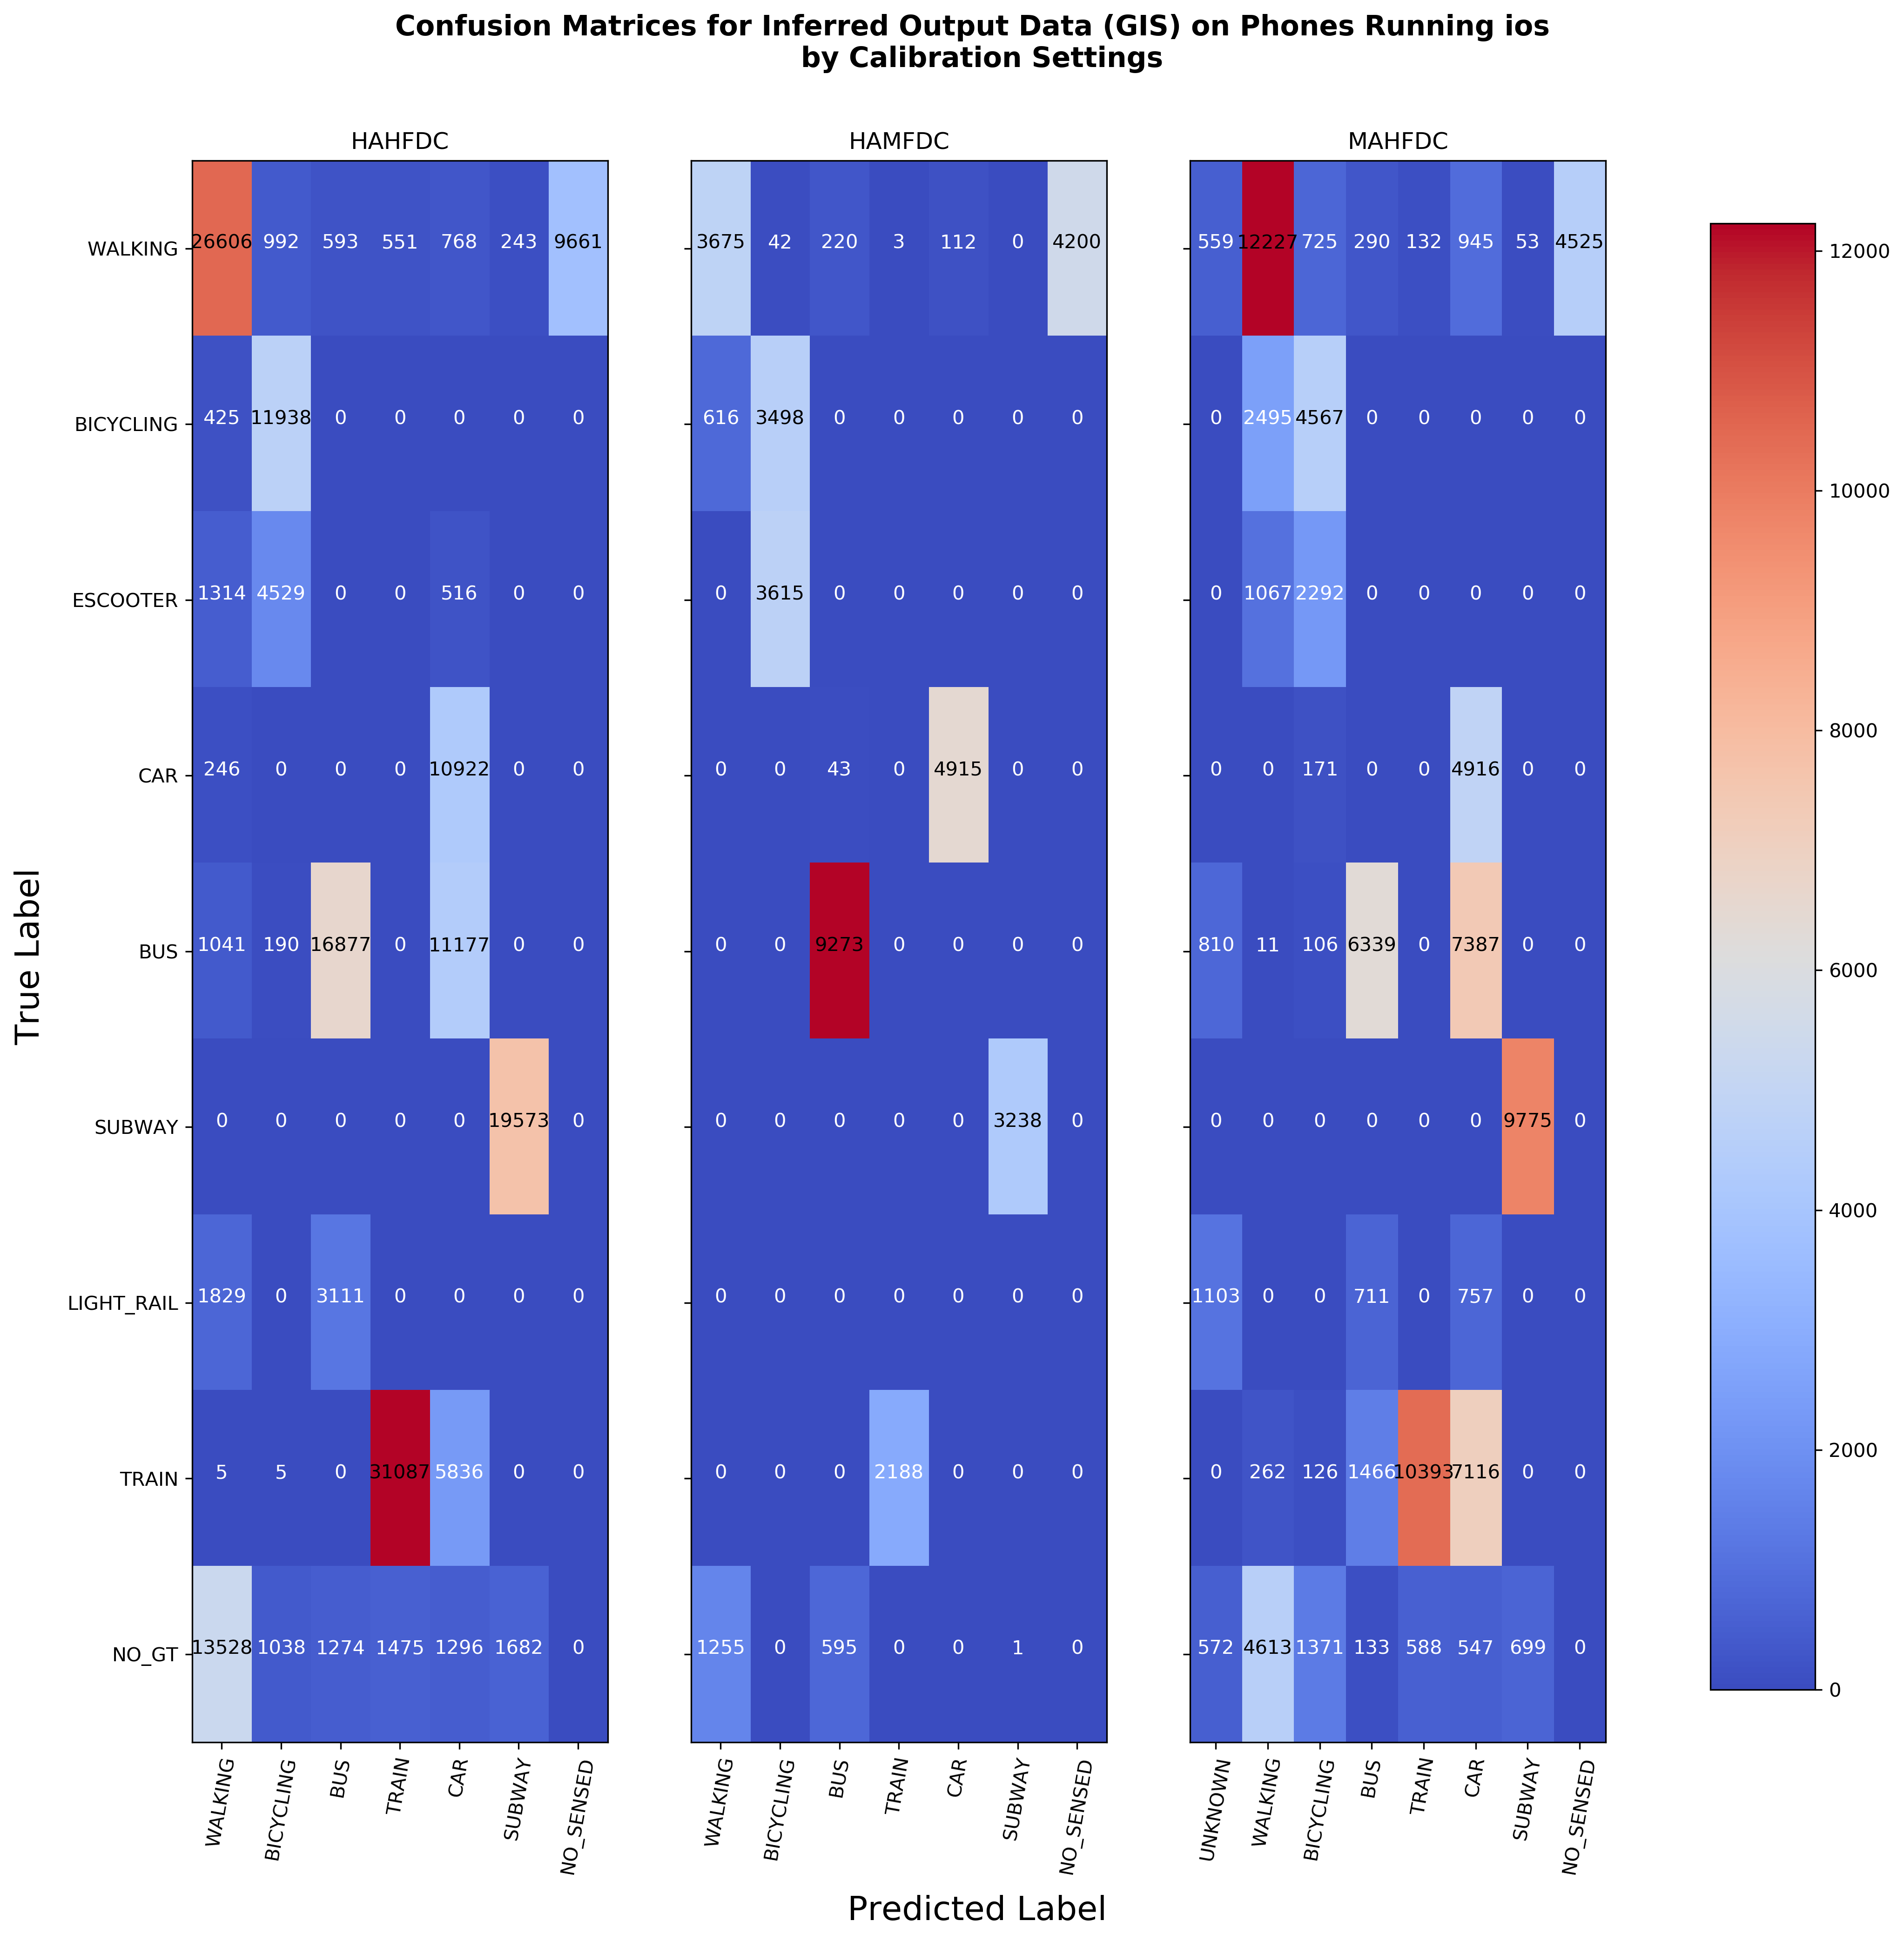

In [40]:
plot_cm('ios', [gisv_la,gisv_sj,gisv_ucb], 'gis', INDEX_MAP=IIM)

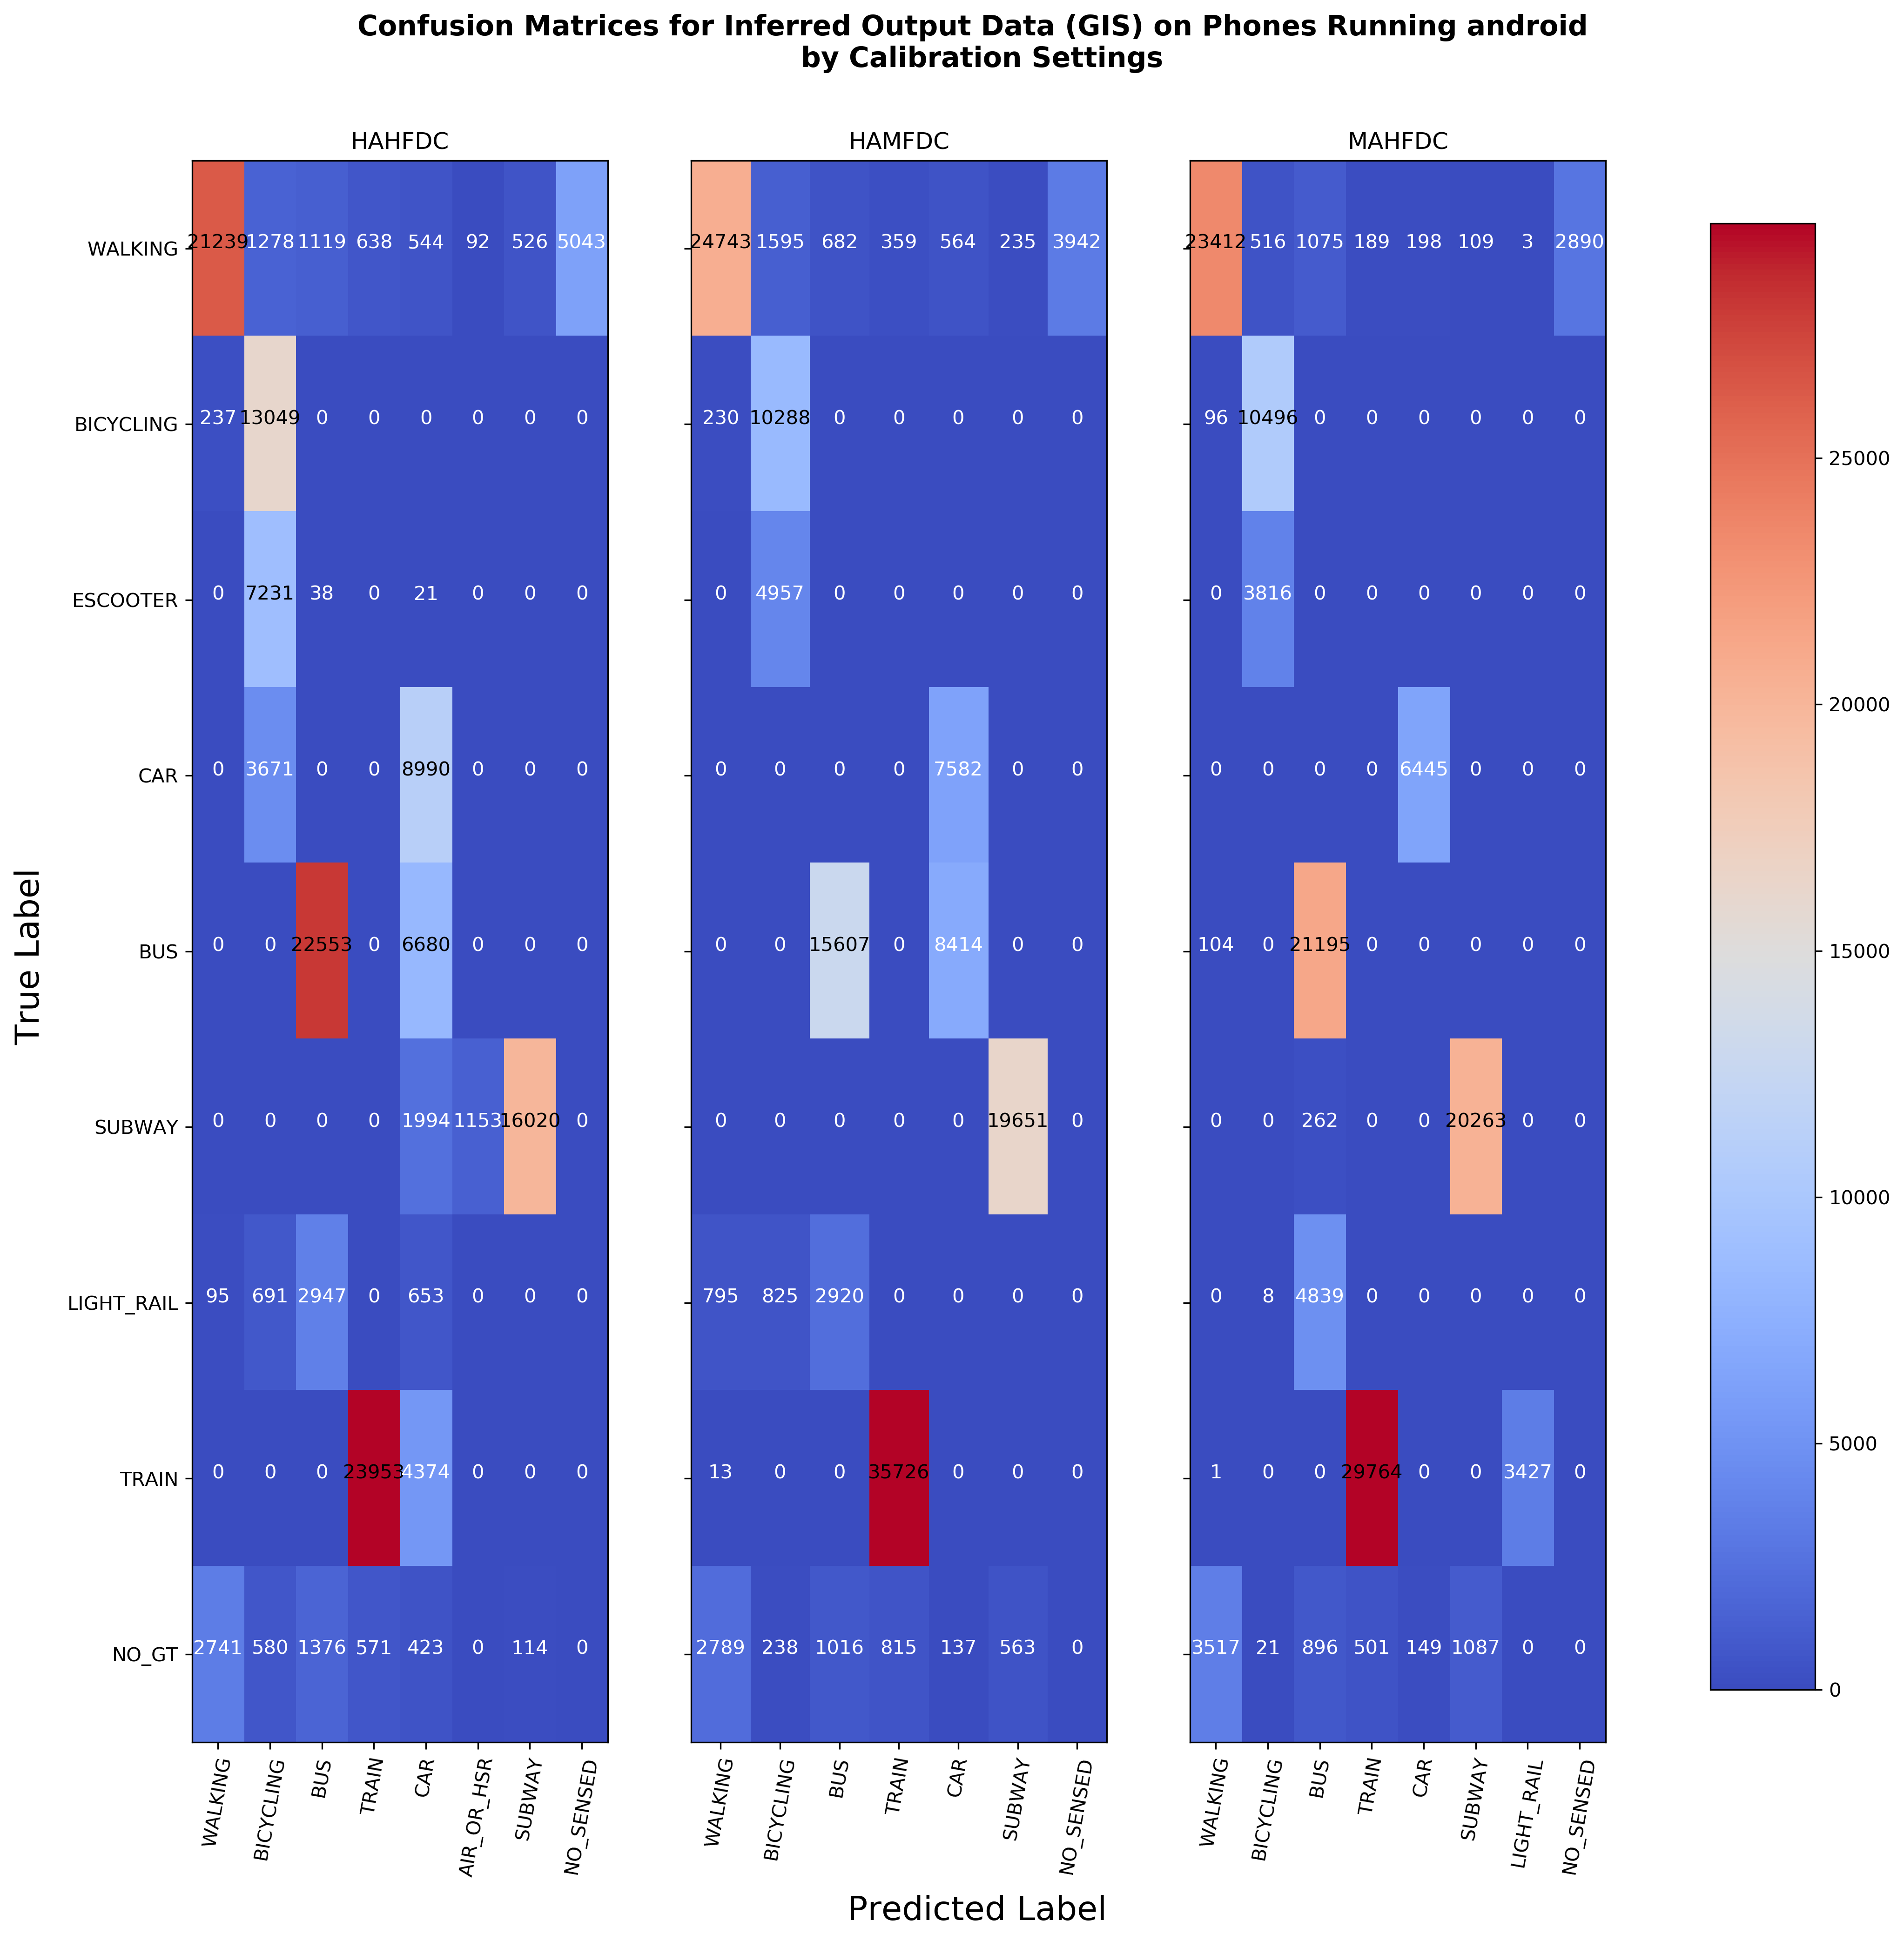

In [41]:
plot_cm('android', [gisv_la,gisv_sj,gisv_ucb], 'gis', INDEX_MAP=IIM)

# Unite Testing

* get_binary_class_in_sec(os, role, pv, BASE_MODE, test=False, test_trip=None)
* get_F_score(os, role, pv, BASE_MODE, beta=1, test=False, test_trip=None)
* get_confusion_matrix(os, role, pv, test=False, test_trip=None)

## Example timelines

### No sensed at the beggining, No GT at the end, Multimodal


* pipeline timeline

WALKING (0.5, 1.35) -> CYCLING (1.35, 2.7) -> WALKING (2.7, 3.5)

* ground truth timeline

WALKING (0, 1.05) -> BICYCLING (1.05, 3.1)

#### binary classifiers
    + TP 
        + [WALKING: 0.55] 
        + [CYCLING: 1.35]
    + FP 
        + [WALKING: 1.10] 
        + [INVALID: 0.5]
    + FN 
        + [WALKING: 0.50] 
        + [CYCLING: 0.70]
        + [INVALID: 0.4]
    + TN 
        + [WALKING: 1.35] 
        + [CYCLING: 1.45]
        + [INVALID: 2.60]
* $F_1$ score
    + [WALKING: 0.41]
    + [CYCLING: 0.79]
    + [INVALID: ....]
    
#### Confusion Matrix


sensed = [WALKING, CYCLING, NO_SENSED]

ground truth = [WALKING, BICYCLING, NO_GT]

origin top left

    [0.55, 0.00, 0.50]
    [0.70, 1.35, 0.00]
    [0.40, 0.00, 0.00]

In [77]:
test_trip = {
    'ss_timeline'  : [{'start_ts' : 0.5, 'end_ts' : 1.35, 'mode' : 'WALKING'},
                      {'start_ts' : 1.35, 'end_ts' : 2.7, 'mode' : 'CYCLING'}, 
                      {'start_ts' : 2.7, 'end_ts' : 3.5, 'mode' : 'WALKING'}],
    'gts_timeline' : [{'start_ts' : 0, 'end_ts' : 1.05, 'mode' : 'WALKING'}, 
                      {'start_ts' : 1.05, 'end_ts' : 3.1, 'mode' : 'BICYCLING'}]
}
test_BMM = {'WALKING' : 'WALKING', 'CYCLING' : 'CYCLING', 'BICYCLING' : 'CYCLING', 'NO_SENSED' : 'INVALID', 'NO_GT' : 'INVALID', 'INVALID' : 'INVALID'}

#### get_binary_class_in_sec

In [78]:
res = get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=test_trip)

In [80]:
assert round(res[0]['WALKING'], 2) == 0.55 and round(res[0]['CYCLING'], 2) == 1.35 and res[0]['INVALID'] == 0 and len(res[0]) == 3, f"TP wrong"
assert round(res[1]['WALKING'], 2) == 1.10 and round(res[1]['INVALID'], 2) == 0.50 and len(res[1]) == 2, f"FP wrong"
assert round(res[2]['WALKING'], 2) == 0.50 and round(res[2]['CYCLING'], 2) == 0.70 and round(res[2]['INVALID'], 2) == 0.40 and len(res[2]) == 3, f"FN wrong"
assert round(res[3]['WALKING'], 2) == 1.35 and round(res[3]['CYCLING'], 2) == 1.45 and round(res[3]['INVALID'], 2) == 2.60 and len(res[2]) == 3, f"TN wrong"

#### get_F_score

In [81]:
res = get_F_score(..., ..., ..., test_BMM, beta=1, test=True, test_trip=test_trip)
assert round(res['WALKING'],2) == 0.41 and round(res['CYCLING'], 2) == 0.79 and res['INVALID'] == 0, f"F_1 scores wrong"

#### get_confusion_matrix

In [82]:
res = get_confusion_matrix(..., ..., ..., test=True, test_trip=test_trip)
df = pd.DataFrame(res).groupby('sensed_mode').sum()
assert 'WALKING' in df.index and 'CYCLING' in df.index and 'NO_SENSED' in df.index, f"INCORRECT INDECIES \n EXPECTED \t 'WALKING', 'CYCLING', 'NO_SENSED' \n GOT \t \t {df.index}"
assert df.loc['WALKING'].loc['WALKING'] == 0.55 and df.loc['WALKING'].loc['BICYCLING'] == 0.70 and round(df.loc['WALKING'].loc['NO_GT'],2) == 0.40
assert df.loc['CYCLING'].loc['WALKING'] == 0 and df.loc['CYCLING'].loc['BICYCLING'] == 1.35 and round(df.loc['CYCLING'].loc['NO_GT'],2) == 0.0
assert round(df.loc['NO_SENSED'].loc['WALKING'], 2) == 0.50 and df.loc['NO_SENSED'].loc['BICYCLING'] == 0.0 and round(df.loc['NO_SENSED'].loc['NO_GT'],2) == 0.0

### No sensed at beggining and end, unimodal

* pipeline timeline
WALKING (0.5, 1.5)

* ground truth timeline
WALKING (0, 2)

#### Multiclass classifiers
* TP
    + WALKING [1]
* FP
    + INVALID [1]
* FN
    + WALKING [1]
* TN
    + INVALID [1]
* $F_1$ score
    + ...
#### Confusion Matrix

sensed mode = ['WALKING', 'NO_SENSED']

ground truth = ['WALKING']

    [1,1]

In [83]:
test_trip = {
    'ss_timeline'  : [{'start_ts' : 0.5, 'end_ts' : 1.5, 'mode' : 'WALKING'}],
    'gts_timeline' : [{'start_ts' : 0, 'end_ts' : 2, 'mode' : 'WALKING'}]
}
test_BMM = {'WALKING' : 'WALKING', 'NO_SENSED' : 'INVALID', 'NO_GT' : 'INVALID', 'INVALID' : 'INVALID'}

In [84]:
res = get_binary_class_in_sec(..., ..., ..., test_BMM, test=True, test_trip=test_trip)

In [85]:
assert res[0]['WALKING'] == 1
assert res[1]['INVALID'] == 1
assert res[2]['WALKING'] == 1
assert res[3]['INVALID'] == 1

In [86]:
res = get_confusion_matrix(..., ..., ..., test=True, test_trip=test_trip)
df = pd.DataFrame(res).groupby('sensed_mode').sum()

WALKING    NO_GT
sensed_mode                  
NO_SENSED   0.500000 0.000000
WALKING     1.000000 0.000000

In [90]:
assert df.loc['WALKING'].loc['WALKING'] == 1
assert df.loc['NO_SENSED'].loc['WALKING'] == 1

AssertionError: 